In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"



import sys

sys.path.append("../src")


import pandas as pd
import numpy as np

import random
import itertools
from sklearn import metrics
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import sys
import os

import math

from utils import number_split, create_mix
from data_process import load_wls_adress_AddDomain
from process_SHAC import load_process_SHAC
from custom_distance import KL



from sklearn.feature_extraction.text import CountVectorizer

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import pickle


from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F


from sentence_transformers import SentenceTransformer

from sklearn.metrics import precision_recall_fscore_support

from transformers import AutoTokenizer, AutoModel


# Test two ways of embedding... same!?

In [ ]:

model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [ ]:
sentence

In [ ]:
embedding.shape

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')


In [ ]:
encoded_input = tokenizer(sentences, max_length = 120, padding=True, truncation=True, return_tensors='pt')


In [ ]:
encoded_input

In [ ]:
with torch.no_grad():
    model_output = model(**encoded_input)


In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [ ]:
model_output['last_hidden_state']

In [ ]:
# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print("Sentence embeddings:")
print(sentence_embeddings)

In [ ]:
sentence_embeddings[0]

In [ ]:
model.encode(sentences[0])

In [ ]:
model.encode(sentences[0])[:20]

In [ ]:
sentence_embeddings[0][:20]

In [ ]:
encoded_input['attention_mask']

In [ ]:
model_output[0]

# Use this Embedding

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
# https://www.sbert.net/index.html

# Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence', 
             'Sentences are passed as a list of string.',
             'The quick brown fox jumps over the lazy dog.']

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)


In [ ]:
embeddings.shape

# Load Data

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

# Split

In [ ]:
n_test = 150
train_test_ratio = 4


valid_full_settings = []
for combination in itertools.product([0.1, 0.5], 
                                    [0.2, 0.6], 
                                     np.arange(0.1, 0.999, 0.1),
                                     np.arange(0, 5, 0.05)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if number_setting is not None:
        valid_full_settings.append(number_setting)
    

In [ ]:
len(valid_full_settings)

In [ ]:
valid_full_settings[0]

In [ ]:
dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= valid_full_settings[0])

In [ ]:
dfs.keys()

In [ ]:
dfs['train']

In [ ]:
dfs['test']

# Sentence BERT

## Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

## Logistic Regression

### All

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=embeddings_X_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=embeddings_X_test)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
embeddings_X_train

In [ ]:
x_train_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_train)
x_test_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(embeddings_X_test)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
# metrics.roc_auc_score(
#                 y_true=y_test,
#                 y_score=y_probs[:,1],
#             )

# metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

# TFIDF

In [ ]:
vectorizer = TfidfVectorizer(use_idf = True,
                                    ngram_range = (1,1))

In [ ]:
vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

In [ ]:
x_train_tfidf = vectorizer.transform(dfs['train']['text']).toarray()
x_test_tfidf = vectorizer.transform(dfs['test']['text']).toarray()

## Logistic Regression

### All features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

### t-SNE

In [ ]:
x_train_tfidf_tsne = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_train_tfidf)
x_test_tfidf_tsne  = TSNE(n_components=30, perplexity=50, method="exact").fit_transform(x_test_tfidf)



In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_tsne, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_tsne)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

In [ ]:
metrics.roc_auc_score(
                y_true=y_test,
                y_score=y_probs[:,1],
            )

In [ ]:
metrics.f1_score(y_true=y_test, y_pred=y_probs[:,1]>0.5)

### PCA

In [ ]:
pca = PCA(n_components=5)

In [ ]:
x_train_tfidf_pca = pca.fit_transform(x_train_tfidf)
x_test_tfidf_pca = pca.fit_transform(x_test_tfidf)


In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
clf.fit(X=x_train_tfidf_pca, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs = clf.predict_proba(X=x_test_tfidf_pca)

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs[:,1])

# Confound: statistical adjustment

## One-hot vector for z

In [ ]:
v = 1
confound_map = {"wls":0, "adress":v}

dfs['train']['confound'] = dfs['train']['domain'].map(confound_map)

dfs['test']['confound'] = dfs['test']['domain'].map(confound_map)


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:
x_embeddings_confound_train = np.concatenate([embeddings_X_train, np.array(dfs['train']['confound']).reshape(-1,1)], axis=1)


In [ ]:
shape_test = embeddings_X_test.shape

a = np.empty((shape_test[0],1))
a.fill(0)
x_embeddings_confound_test_z0 = np.concatenate([embeddings_X_test, a], axis=1)

a = np.empty((shape_test[0],1))
a.fill(v)
x_embeddings_confound_test_z1 = np.concatenate([embeddings_X_test, a], axis=1)

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_z0 = clf.predict_proba(X=x_embeddings_confound_test_z0)
y_probs_z1 = clf.predict_proba(X=x_embeddings_confound_test_z1)

In [ ]:
p_z = []

# NOTE: the order here is important!!! Here, wls -> df0, adress -> df1
p_z.append(sum(dfs['train']['domain'] == 'wls')/len(dfs['train']))
p_z.append(sum(dfs['train']['domain'] == 'adress')/len(dfs['train']))


In [ ]:
p_z

In [ ]:
y_probs_z0[:5,:]

In [ ]:
y_probs_z0[:5,:] * p_z[0]

In [ ]:
y_probs_z1[:5,:]

In [ ]:
y_probs_z1[:5,:] * p_z[1]

In [ ]:
y_probs_confound = y_probs_z0 * p_z[0] + y_probs_z1 * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Confound: statistical adjustment

## Dummy Coding for z

In [ ]:
z_Categories = ["wls","adress"]
n_zCats = len(z_Categories)

y_Categories = [0,1]
n_yCats = len(y_Categories)

In [ ]:
pd.Categorical(dfs['train']['domain'], categories=z_Categories)

In [ ]:
pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v

In [ ]:
confounders_train = pd.get_dummies(pd.Categorical(dfs['train']['domain'], categories=z_Categories), prefix="confounder") * v
confounders_test = pd.get_dummies(pd.Categorical(dfs['test']['domain'], categories=z_Categories), prefix="confounder") * v


## Sentence BERT

### Encode

In [ ]:
embeddings_X_train = model.encode(dfs['train']['text'])
embeddings_X_test = model.encode(dfs['test']['text'])

In [ ]:
y_train = dfs['train']['label']
y_test = dfs['test']['label']

n_test = len(y_test)

In [ ]:
n_test

### Logistic Regression

#### All Features

In [ ]:
clf  = LogisticRegression(penalty = "l2", C = 1, max_iter = 100, class_weight = None, solver="liblinear")

In [ ]:
embeddings_X_train

In [ ]:

x_embeddings_confound_train = np.concatenate([embeddings_X_train, confounders_train], axis=1)


In [ ]:
len(z_Categories)

In [ ]:
a = np.empty(())

In [ ]:
x_embeddings_confound_test_ls = []

for i in range(n_zCats):
    

    a = np.empty((n_test, n_zCats))
    a.fill(0)
    a[:,i] = v
    _ = np.concatenate([embeddings_X_test, a], axis=1)
    x_embeddings_confound_test_ls.append(_)

In [ ]:
x_embeddings_confound_test_ls[0]

In [ ]:
clf.fit(X=x_embeddings_confound_train, y=y_train)

In [ ]:
clf.classes_

In [ ]:
y_probs_ls = []

for i in range(n_zCats):
    _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
    y_probs_ls.append(_y_probs)


In [ ]:
p_z = []

for i in z_Categories:
    p_z.append(sum(dfs['train']['domain'] == i)/len(dfs['train']))

In [ ]:
p_z

In [ ]:
y_probs_confound = np.empty((n_test, n_yCats))
y_probs_confound.fill(0)

In [ ]:
for i in range(n_zCats):
    y_probs_confound += y_probs_ls[i] * p_z[i]

In [ ]:
y_probs_confound = y_probs_ls[0] * p_z[0] + y_probs_ls[1] * p_z[1]

In [ ]:
metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1])

# Build for multiple runs

## WLS/Pitts

In [ ]:
df_wls_merge = load_wls_adress_AddDomain(dt='wls')
df_adress = load_wls_adress_AddDomain(dt='adress')

## SHAC

In [2]:
df_shac = load_process_SHAC(replaceNA="all")

In [3]:
df_shac

,id,Drug,Alcohol,Tobacco,SubstanceAgg,set,location,text
0,3407,True,False,False,True,train,uw,Social History: Work: Unemployed Lives with m...
1,3313,False,True,False,True,train,uw,SOCIAL HISTORY: Living situation: Comfortabl...
2,3045,True,False,True,True,train,uw,HABITS: Tobacco Use: Approximately 20 pack-ye...
3,4399,False,True,True,True,train,uw,Social History: Immigrated from [LOCATION] in ...
4,3637,False,False,True,True,train,uw,HABITS: Tobacco Use: Formerly smoked 1-2 ciga...
...,...,...,...,...,...,...,...,...
4400,2884,True,True,False,True,test,mimic,Social History: lives w/ mother in [**Name2 (N...
4401,2728,False,False,True,True,test,mimic,Social History: lives with wife (recent nursin...
4402,2854,False,True,True,True,test,mimic,"Social History: quit smoking several yrs ago, ..."
4403,2726,False,False,False,False,test,mimic,"Social History: Denies Tob, EtOH, or Illicit d..."


In [4]:
## Note: this doesn't have any effect on modeling... Used as placeholder ONLY
df_shac["label_binary"] = df_shac.apply(lambda x: 1 if x["Drug"] else 0, axis=1)

df_shac["dfSource"] = df_shac["location"]

In [5]:
df_shac_uw = df_shac.query("location == 'uw'").reset_index(drop=True)
df_shac_mimic = df_shac.query("location == 'mimic'").reset_index(drop=True)


In [6]:
df_shac.groupby(["location",]).size()

location
mimic    1877
uw       2528
dtype: int64

In [7]:
df_shac.groupby(["location","Drug"]).size()

location  Drug 
mimic     False    1506
          True      371
uw        False    1488
          True     1040
dtype: int64

## SHAC LLaMa Embeddings - Averaged - v1 65b

In [3]:
df = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_SHAC.pkl")

In [4]:
df_shac_llama_average_uw = df.query("location == 'uw'").reset_index(drop=True)
df_shac_llama_average_mimic = df.query("location == 'mimic'").reset_index(drop=True)


In [6]:
df_shac_uw = df_shac_llama_average_uw.copy()
df_shac_mimic = df_shac_llama_average_mimic.copy()

## SHAC LLaMa Embeddings - Averaged - v2 7b/13b/70b-q

In [2]:
# df = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_SHAC_llamav2_7b.pkl")

# df = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_SHAC_llamav2_13b.pkl")
df = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_SHAC_llamav2_70b_8quant.pkl")

In [3]:
df_shac_llama_average_uw = df.query("location == 'uw'").reset_index(drop=True)
df_shac_llama_average_mimic = df.query("location == 'mimic'").reset_index(drop=True)


In [4]:
df_shac_uw = df_shac_llama_average_uw.copy()
df_shac_mimic = df_shac_llama_average_mimic.copy()

## IMDB Horror vs Family

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_family.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_family = df_imdb.query("domain == 'Family'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_family.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_family.groupby("label_binary").size())

## IMDB Horror vs Documentary

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_documentary.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_documentary = df_imdb.query("domain == 'Documentary'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_documentary.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_documentary.groupby("label_binary").size())

In [ ]:
500/776

## IMDB Horror vs non Horror

In [ ]:
df_imdb = pd.read_csv("../data/aclImdb/horror_nonhorror.csv")

In [ ]:
df_imdb

In [ ]:
df_imdb['label_binary'] = df_imdb['label'].map({"pos":1,"neg":0})

In [ ]:
df_imdb_horror = df_imdb.query("domain == 'Horror'").reset_index(drop=True)


df_imdb_nonhorror = df_imdb.query("domain == 'nonHorror'").reset_index(drop=True)


In [ ]:
print(df_imdb_horror.groupby("label").size())
print(df_imdb_nonhorror.groupby("label").size())

In [ ]:
print(df_imdb_horror.groupby("label_binary").size())
print(df_imdb_nonhorror.groupby("label_binary").size())

In [ ]:
10/18

In [ ]:
# del df_imdb_horror, df_imdb_nonhorror, df_imdb, df_imdb_family, df_imdb_documentary

In [ ]:
valid_full_settings[0]['mix_param_dict']

In [ ]:
 "_".join([str(x) for x in valid_full_settings[0]['mix_param_dict']])

In [ ]:
"_".join([f"{k}_{v:.4f}" for k,v in valid_full_settings[0]['mix_param_dict'].items()])

## Yelp Seafoof: FL vs PA

In [ ]:
df_FL = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_FL.csv")
df_PA = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_seafood_PA.csv")

## Yelp Mexican: AZ vs MO

In [ ]:
df_AZ = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_AZ.csv")
df_MO = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_mexican_MO.csv")

## Yelp Year: before(and in) 2015 vs after(and in) 2020

In [ ]:
df_before2015 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_before2015.csv")
df_after2020 = pd.read_csv("/bime-munin/xiruod/data/yelp_dataset/processed/yelp_year_after2020.csv")

## Hate Speech

In [2]:
import pathlib

In [3]:
df_dynGen = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/Dynamically-Generated-Hate-Speech-Dataset/Dynamically Generated Hate Dataset v0.2.3.csv",)
df_dynGen['label_binary'] = df_dynGen['label'].map({"hate":1, "nothate":0})

In [4]:
df_dynGen["dfSource"] = "dynGen"

In [5]:
df_dynGen['label'].unique()

array(['hate', 'nothate'], dtype=object)

In [6]:
df_dynGen['label_binary'].unique()

array([1, 0])

In [7]:
ls_allFiles = pathlib.Path("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/all_files/").glob("*.txt")

ls_id = []
ls_text = []

for ifile in ls_allFiles:
    ls_id.append(ifile.name.split(".txt")[0])
    with open(ifile, "r") as f:
        ls_text.append(f.read())

df_wsf_raw = pd.DataFrame({"file_id":ls_id, "text":ls_text})

df_wsf_annotation = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/hate-speech-dataset/annotations_metadata.csv")

df_wsf = df_wsf_raw.merge(df_wsf_annotation, on="file_id", how="inner")

In [8]:
df_wsf.head()

,file_id,text,user_id,subforum_id,num_contexts,label
0,13480343_3,It can cause rage .,573459,1345,0,noHate
1,13341044_1,Obama has membership in Prince Hall ( for blac...,572139,1345,0,noHate
2,14036870_1,London is a dead zone as far as anyone White i...,572058,1387,0,hate
3,13861984_1,There was a small Nigerian man that lived in t...,574905,1391,0,noHate
4,13477847_2,New Square Meats allegedly sold nearly 2 milli...,573739,1345,0,noHate


In [9]:
df_wsf['label'].unique()

array(['noHate', 'hate', 'relation', 'idk/skip'], dtype=object)

In [10]:
df_wsf.groupby(['label']).size()

label
hate        1196
idk/skip      73
noHate      9507
relation     168
dtype: int64

In [11]:
df_wsf = df_wsf[df_wsf['label'].isin(['hate','noHate'])].reset_index(drop=True)

df_wsf['label_binary'] = df_wsf['label'].map({"hate":1,"noHate":0})

In [12]:
df_wsf['label_binary'].unique()

array([0, 1])

In [13]:
df_wsf["dfSource"] = "wsf"

In [14]:
df_yt = pd.read_csv("/bime-munin/xiruod/data/hateSpeech_Bulla2023/HS_YouTube/IMSyPP_EN_YouTube_comments_evaluation_context.csv")


In [15]:
df_yt.groupby(['Type'],  dropna=False).size()

Type
0. appropriate      14723
1. inappropriate      198
2. offensive         5531
3. violent            102
NaN                   964
dtype: int64

In [16]:
df_yt = df_yt.query("Type.isin(['0. appropriate', '2. offensive'])").reset_index(drop=True)

df_yt['label_binary'] = df_yt['Type'].map({"2. offensive":1, "0. appropriate": 0})

In [17]:
df_yt.groupby("label_binary", dropna=False).size()

label_binary
0    14723
1     5531
dtype: int64

In [18]:
df_yt = df_yt.rename(columns={"Text":"text"})

## Hate Speech LLaMa Embeddings - Averaged - v2 7b/13b

In [3]:
# df_dynGen = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_dynGen_llamav2_7b.pkl")

# df_dynGen = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_dynGen_llamav2_13b.pkl")
# df_dynGen = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_dynGen_llamav2_70b_8quant.pkl")

# df_dynGen = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_Permute_HS_dynGen_llamav2_7b.pkl")
df_dynGen = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_Permute_HS_dynGen_llamav2_13b.pkl")

In [2]:
# df_wsf = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_wsf_llamav2_7b.pkl")
# df_wsf = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_wsf_llamav2_13b.pkl")
# df_wsf = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_HS_wsf_llamav2_70b_8quant.pkl")

# df_wsf = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_Permute_HS_wsf_llamav2_7b.pkl")
df_wsf = pd.read_pickle("../output/LLaMaEmbeddings/df_Average_Permute_HS_wsf_llamav2_13b.pkl")


In [4]:
df_wsf.groupby("label").size()

label
hate      1196
noHate    9507
dtype: int64

## WILDS

In [ ]:
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader

# Load the full dataset, and download it if necessary
dataset = get_dataset(dataset="civilcomments", download=True)


In [ ]:
# Get the test set
train_data = dataset.get_subset("train")
train_loader = get_train_loader("standard", train_data, batch_size=16)


In [ ]:
dataset.metadata_fields

In [ ]:
from wilds.common.grouper import CombinatorialGrouper
# grouper = CombinatorialGrouper(dataset, dataset.metadata_fields[:8])


# z_var = "christian"
# z_var = "white"
z_var = "male"


grouper = CombinatorialGrouper(dataset, [z_var])

In [ ]:
x_ls = []
y_true_ls = []
metadata_ls = []

for labeled_batch in train_loader:
    x, y_true, metadata = labeled_batch
    x_ls.extend(x)
    y_true_ls.extend(y_true.numpy())
    metadata_ls.append(metadata)

In [ ]:
df = pd.DataFrame({"text": x_ls, "y_true":y_true_ls,})

metadata_df = pd.DataFrame(torch.concat(metadata_ls).numpy())
metadata_df.columns = dataset.metadata_fields

In [ ]:
df = pd.concat([df, metadata_df], axis=1)

In [ ]:
df

In [ ]:
df.groupby([z_var, "y_true"], dropna=False).size()

In [ ]:
df['Christian'] = np.where(df['christian'] == 1, "christian", "nonchristian")

In [ ]:
df_christian = df.query("christian == 1").reset_index(drop=True)
df_nonchristian = df.query("christian == 0").reset_index(drop=True)

In [ ]:
df_christian.shape

In [ ]:
df_nonchristian.shape

In [ ]:
df['White'] = np.where(df['white'] == 1, "white", "notwhite")

In [ ]:
df_white = df.query("white == 1").reset_index(drop=True)
df_notwhite = df.query("white == 0").reset_index(drop=True)

In [ ]:
df_white.shape

In [ ]:
df_notwhite.shape

In [ ]:
df['Male'] = np.where(df['male'] == 1, "male", "notmale")

In [ ]:
df_male = df.query("male == 1").reset_index(drop=True)
df_notmale = df.query("male == 0").reset_index(drop=True)

In [ ]:
df_male.shape

In [ ]:
df_notmale.shape

# Split

In [ ]:
# p_pos_train = p_pos_train_z0 * p_mix_z0 + p_pos_train_z1 * p_mix_z1 = 0.5

# p_pos_train = p_pos_test



In [ ]:
# SHAC-Drug - full, long experiments
n_test = 500
train_test_ratio = 4

p_pos_train_z0=0.2
p_pos_train_z1=0.5

valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     np.arange(0.01, 0.99, 0.01),
                                     np.arange(0, 5, 0.01)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# SHAC-Drug - for short experiments! n_test = 500 -- AMIA
n_test = 500
train_test_ratio = 4


p_pos_train_z0=0.5
p_pos_train_z1=0.2

valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     [0.3,0.5,0.6],
                                     np.arange(0, 5, 0.1)
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# SHAC-Drug - for short experiments! n_test = 500 -- test
n_test = 500
train_test_ratio = 4


p_pos_train_z0=0.5
p_pos_train_z1=0.2
numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product([p_pos_train_z0], 
                                     [p_pos_train_z1], 
                                     [0.3,0.5,0.6],
                                     alpha_test_ls,
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [8]:
# SHAC-Drug - Balanced Alpha
n_test = 500
train_test_ratio = 4


p_pos_train_z0_ls = np.arange(0, 1, 0.1) # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = np.arange(0, 1, 0.1) # probability of test set examples drawn from site/domain z1 being positive


p_mix_z1_ls     = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    
    

/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:29: RuntimeWarning: invalid value encountered in scalar divide
  alpha_train = p_pos_train_z1 / p_pos_train_z0
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_train = p_pos_train_z1 / p_pos_train_z0


In [8]:
# SHAC-Drug - Balanced Alpha - n_test=200 for LLAMA2
n_test = 200
train_test_ratio = 4


p_pos_train_z0_ls = np.arange(0, 1, 0.1) # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = np.arange(0, 1, 0.1) # probability of test set examples drawn from site/domain z1 being positive


p_mix_z1_ls     = np.arange(0, 1, 0.05) 

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None) :
        # if not (round(number_setting['mix_param_dict']['C_y'], 4) in [0.2,0.48,0.72]):
        #     continue
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    
    

/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:29: RuntimeWarning: invalid value encountered in scalar divide
  alpha_train = p_pos_train_z1 / p_pos_train_z0
/home/NETID/xiruod/projects/DeconDTN/notebooks_xiruo/../src/utils.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  alpha_train = p_pos_train_z1 / p_pos_train_z0


In [ ]:
# # imdb setting
# n_test = 500
# train_test_ratio = 4

p_pos_train_z0 = 0.3
p_pos_train_z1 = 0.5

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.1)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp seafood PA vs FL setting
# n_test = 500
# train_test_ratio = 4


p_pos_train_z0 = 0.8
p_pos_train_z1 = 0.6

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp mexican AZ vs MO setting
# n_test = 500
# train_test_ratio = 4

p_pos_train_z0 = 0.65
p_pos_train_z1 = 0.5


# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.05),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [ ]:
# # yelp year before 2015 vs after 2020 setting
# n_test = 10000
# train_test_ratio = 4


p_pos_train_z0 = 0.3
p_pos_train_z1 = 0.9

# valid_full_settings = []
# for combination in itertools.product([p_pos_train_z0], 
#                                      [p_pos_train_z1], 
#                                      np.arange(0.1, 0.9, 0.1),
#                                      np.arange(0, 10, 0.05)
#                                     ):
    

#     number_setting = number_split(p_pos_train_z0=combination[0], 
#                            p_pos_train_z1 = combination[1], 
#                            p_mix_z1 = combination[2], alpha_test = combination[3],
#                            train_test_ratio = train_test_ratio, 
#                            n_test=n_test,
#                                   verbose=False
#                                  )

#     if (number_setting is not None):
#         if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
#             valid_full_settings.append(number_setting)
    

In [19]:
df_dynGen.shape

(41144, 15)

In [20]:
df_wsf.shape

(10703, 8)

In [19]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11)
n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        # if not (round(number_setting['mix_param_dict']['C_y'], 4) in [0.36, 0.44, 0.52]):
        #     continue
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [14]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11) ======= SHORTER version!!!
n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.5, 0.8] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.5, 0.8] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.5, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        # if not (round(number_setting['mix_param_dict']['C_y'], 4) in [0.36, 0.44, 0.52]):
        #     continue
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# Hate Speech Detection: df_dynGen (0.55) vs df_wsf (0.11) 
############# For Perfect Balance of 0.5 and alpha_train=alpha_test=1 ONLY!!

n_test = 1000
train_test_ratio = 4


p_pos_train_z0_ls = np.arange(0,1,0.05) # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = np.arange(0,1,0.05) # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.5] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = [1]


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [ ]:
# WILDS: CivilComments
# by Christian: df_christian (0.11) vs df_nonchristian (0.11)
# by White: df_white vs df_notwhite
# by Male: df_male vs df_notmale

n_test = 500
train_test_ratio = 4


p_pos_train_z0_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of training set examples drawn from site/domain z0 being positive
p_pos_train_z1_ls = [0.2, 0.4, 0.5, 0.6, 0.8, 0.9] # probability of test set examples drawn from site/domain z1 being positive

p_mix_z1_ls     = [0.2, 0.4, 0.6, 0.8] # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

In [15]:
len(valid_full_settings)

1241

In [23]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_full_settings])

/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/NETID/xiruod/anaconda3/envs/llama2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, '$P_{test}(y=1|z=1)$')

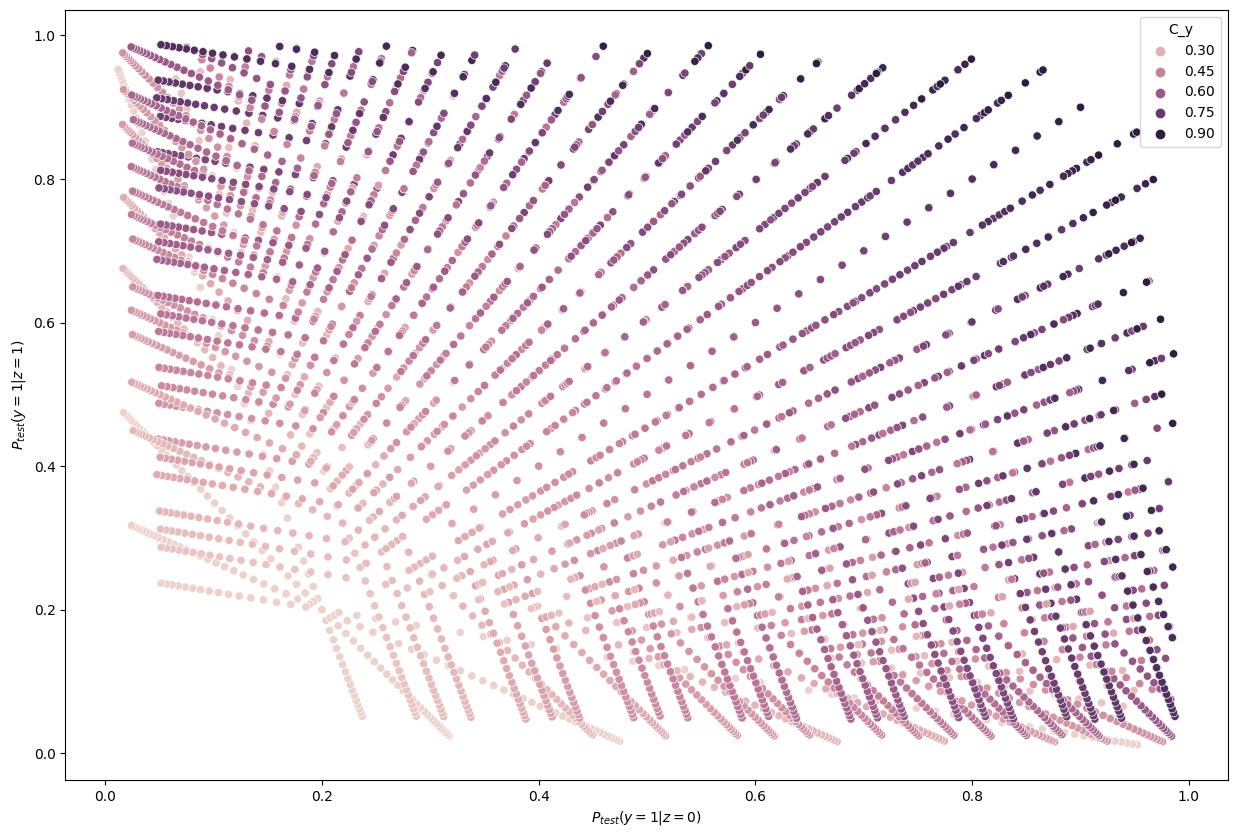

In [24]:
plt.figure(figsize=(15,10))
ax = sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df, hue="C_y")
ax.set_xlabel(r"$P_{test}(y=1|z=0)$")
ax.set_ylabel(r"$P_{test}(y=1|z=1)$")

In [25]:
# df_dynGen.shape 

In [26]:
# run for check valid settings

import warnings; warnings.simplefilter('ignore')

label='label_binary'
df0 = df_dynGen
df1 = df_wsf

# label='Drug'
# df0 = df_shac_uw
# df1 = df_shac_mimic

# label='y_true'
# df0 = df_christian
# df1 = df_nonchristian
# df0 = df_white
# df1 = df_notwhite
# df0 = df_male
# df1 = df_notmale

valid_n_full_settings = []

for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=222
                        )

        if dfs is None:
            continue
        
        valid_n_full_settings.append(c)

100%|███████████████████| 5642/5642 [01:22<00:00, 68.36it/s]


In [27]:
len(valid_n_full_settings)

3194

In [28]:
tmp_df = pd.DataFrame([st['mix_param_dict'] for st in valid_n_full_settings])

<Axes: xlabel='p_pos_test_z0', ylabel='p_pos_test_z1'>

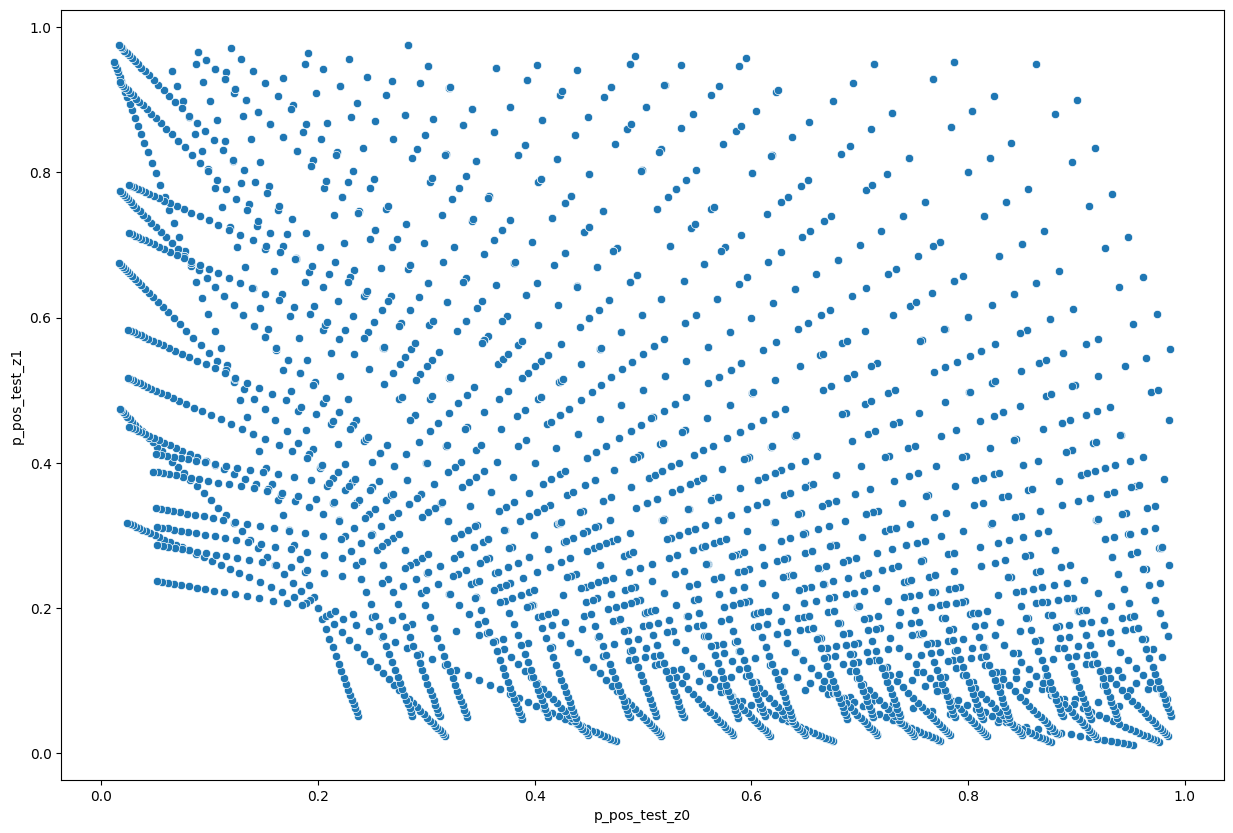

In [29]:
plt.figure(figsize=(15,10))
sns.scatterplot(x="p_pos_test_z0", y="p_pos_test_z1", data=tmp_df)

In [16]:
tmp_df.alpha_train.unique()

array([1.        , 2.        , 2.5       , 3.        , 4.        ,
       4.5       , 0.5       , 1.25      , 1.5       , 2.25      ,
       0.4       , 0.8       , 1.2       , 1.6       , 1.8       ,
       0.33333333, 0.66666667, 0.83333333, 1.33333333, 1.5       ,
       0.25      , 0.625     , 0.75      , 1.125     , 0.22222222,
       0.44444444, 0.55555556, 0.66666667, 0.88888889])

In [17]:
tmp_df.C_y.unique()

array([0.2 , 0.2 , 0.24, 0.28, 0.32, 0.26, 0.36, 0.32, 0.34, 0.36, 0.24,
       0.4 , 0.4 , 0.42, 0.44, 0.44, 0.48, 0.48, 0.5 , 0.38, 0.48, 0.46,
       0.5 , 0.52, 0.54, 0.56, 0.58, 0.58, 0.6 , 0.64, 0.66, 0.68, 0.72,
       0.74, 0.68, 0.76, 0.72, 0.8 , 0.82, 0.62, 0.34, 0.8 , 0.7 , 0.6 ,
       0.82, 0.74, 0.84, 0.78, 0.88, 0.9 ])

In [18]:
valid_n_full_settings[75]

{'n_train': 4000,
 'n_test': 1000,
 'n_z0_pos_train': 480,
 'n_z0_neg_train': 1920,
 'n_z0_pos_test': 172,
 'n_z0_neg_test': 428,
 'n_z1_pos_train': 320,
 'n_z1_neg_train': 1280,
 'n_z1_pos_test': 28,
 'n_z1_neg_test': 372,
 'mix_param_dict': {'p_pos_train_z0': 0.2,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.2,
  'p_pos_test': 0.2,
  'p_mix_z0': 0.6,
  'p_mix_z1': 0.4,
  'alpha_train': 1.0,
  'alpha_test': 0.23939204936916333,
  'p_pos_test_z0': 0.28745675834343287,
  'p_pos_test_z1': 0.06881486248485073,
  'C_y': 0.2,
  'C_z': 0.4}}

Text(0.5, 0, '$log(\\alpha_{test})$')

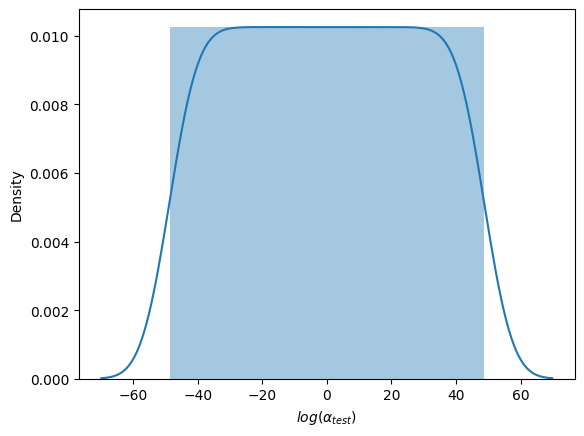

In [19]:
import seaborn as sns
ax = sns.distplot(np.log(alpha_test_ls))
ax.set_xlabel(r"$log(\alpha_{test})$")


In [20]:
numvals = 7
base = 2
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


In [21]:
alpha_test_ls

array([0.125, 0.25 , 0.5  , 1.   , 2.   , 4.   , 8.   ])

# Logistic Regression

In [ ]:
# transform = "Sentence-BERT"
transform = "binaryUnigram"


model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["wls","adress"]
# label='label'



# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic

z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic


# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_vanilla = []
valid_n_full_settings = []

for iRun in range(5):
    
    

    _rand = random.randint(0, 2**32 - 1)
    print(_rand)
    
    print(iRun)
    for c in tqdm(valid_full_settings):
    # for c in test_settings:


        c = c.copy()
        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=_rand
                        )

        if dfs is None:
            continue
        c['run'] = iRun
        valid_n_full_settings.append(c)
        

        if transform == "Sentence-BERT":
            # use Sentence-BERT to encode sentences
            x_transform_train = model.encode(dfs['train'][txt_col])
            x_transform_test = model.encode(dfs['test'][txt_col])
        if transform == "binaryUnigram":
            x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
            x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()

    # tfidf could be tricky...
    # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
    #     elif transform == "tfidf":
    #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

    #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

    #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
    #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

        y_train = dfs['train'][label]
        y_test = dfs['test'][label]

        n_test = len(y_test)




        confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
        confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


        #####################  Confound: statistical Adjustment
        clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        # for training set: add confounder as dummy variables
        x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

        # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
        x_embeddings_confound_test_ls = []

        for i in range(n_zCats):
            a = np.empty((n_test, n_zCats))
            a.fill(0)
            a[:,i] = v
            _ = np.concatenate([x_transform_test, a], axis=1)
            x_embeddings_confound_test_ls.append(_)


        # fit the training data, add confounding dummy variables as predictors
        clf.fit(X=x_embeddings_confound_train, y=y_train)

        # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
        y_probs_ls = []

        for i in range(n_zCats):
            _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
            y_probs_ls.append(_y_probs)


        # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
        p_z = []

        for i in z_Categories:
            p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


        # calculate P(Y|X): sum(P(y|x,z) * P(z))
        y_probs_confound = np.empty((n_test, n_yCats))
        y_probs_confound.fill(0)

        for i in range(n_zCats):
            y_probs_confound += y_probs_ls[i] * p_z[i]



        auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))


        #####################  Simple Logistic Regression, WITHOUT confounder
        clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

        clf_vanilla.fit(X=x_transform_train, y=y_train)


        y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


        auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))


############  Put Results in DataFrame, with extra information (a little redundant)

# organize results in DataFrame
df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                        "auprc_logistic_vanilla": auprc_logistic_vanilla})


for k in valid_n_full_settings[0]['mix_param_dict'].keys():
    df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

for k in valid_n_full_settings[0].keys():
    if k != "mix_param_dict":
        df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

# save to file
with open(f"../output/regressionSHAC/05_02_{n_test}_{penalty}_C{C}_V{v}.pkl", "wb") as f:
    pickle.dump(df_eval, file=f)

In [ ]:
np.stack(df['LLaMaEmbeddings']).shape

## Save for AMIA

In [ ]:
#### AMIA 2023 Main


import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
transform = "Sentence-BERT"
# transform = "binaryUnigram"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic


##### Update to Address Reviewers' comments for AMIA Paper + ClinicalBERT
# transform = "Clinical-BERT"

runs = 5

tokenizer = AutoTokenizer.from_pretrained("medicalai/ClinicalBERT")
model = AutoModel.from_pretrained("medicalai/ClinicalBERT")

vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic


##### Test for LLaMa
# transform = "LLaMaAverage"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic









# z_Categories = ["mimic", "uw"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_mimic
# df1 = df_shac_uw

# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)

# add confounder. v is the scale for confounder
# v = 100

# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# C=1
penalty = "l2"
solver = "lbfgs"
# C = 5


random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], [1,1],[1,100]]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform == "LLaMaAverage":
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

                

        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
            confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []

            for i in range(n_zCats):
                a = np.empty((n_test, n_zCats))
                a.fill(0)
                a[:,i] = v
                _ = np.concatenate([x_transform_test, a], axis=1)
                x_embeddings_confound_test_ls.append(_)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    # save to file
    # outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

## Experiments - LR

In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
# transform = "Sentence-BERT"
# transform = "binaryUnigram"
transform = "tfidf"

runs = 5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')


### Hate Speech
z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
label='label_binary'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "dfSource"
df0 = df_dynGen
df1 = df_wsf
outdir = f"../output/regressionHateSpeechBalanceAlpha"

### SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"



### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020




##### Test for LLaMa Average Embeddings
## SHAC

# # transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"

# runs = 5

# # SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

## Hate Speech

# transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"
# transform = "LLaMaAverageV2_7B_Permute"
# transform = "LLaMaAverageV2_13B_Permute"


# runs = 5

# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"



os.makedirs(outdir, exist_ok=True)


y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            
            
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
                
            # #### TO DELETE: For results on Selected C_y ONLY!!!!!!!!!
            # if round(c['mix_param_dict']['C_y'], 4) not in [0.36, 0.44, 0.52, 0.24, 0.54, 0.84]:
            #     continue
                
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform in ["LLaMaAverage", "LLaMaAverageV2_7B", "LLaMaAverageV2_13B", "LLaMaAverageV2_70B_8Quant", "LLaMaAverageV2_7B_Permute", "LLaMaAverageV2_13B_Permute"]:
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

            # tfidf could be tricky...
            # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
            if transform == "tfidf":
                vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

                # vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))
                vectorizer.fit(dfs['train']['text'])

                x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
                x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()


        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            confounders_train = pd.get_dummies(pd.Categorical(dfs['train'][domain_col], categories=z_Categories), prefix="confounder") * v
            confounders_test = pd.get_dummies(pd.Categorical(dfs['test'][domain_col], categories=z_Categories), prefix="confounder") * v


            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = np.concatenate([x_transform_train, confounders_train], axis=1)

            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []

            for i in range(n_zCats):
                a = np.empty((n_test, n_zCats))
                a.fill(0)
                a[:,i] = v
                _ = np.concatenate([x_transform_test, a], axis=1)
                x_embeddings_confound_test_ls.append(_)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


 25%|████████▉                           | 1399/5642 [59:18<4:46:22,  4.05s/it]

In [15]:
outname

'../output/regressionHateSpeechBalanceAlpha/LLaMaAverageV2_7B_Permute_ntest_1000_l2_C1_V10.pkl'

In [16]:
df_eval.shape

(15970, 47)

In [ ]:
x_transform_train.shape

In [ ]:
len(valid_n_full_settings)

In [ ]:
df_eval

In [ ]:
df_eval['run'].unique()

In [ ]:
df_eval.shape

In [ ]:
p_z

In [ ]:
df_eval.query("(alpha_test == 5)")

## Experiments - Simple Permutation for Sites (Move 1 step) + LR

In [9]:
def shiftBy(x_original, z_ls, z_Category):
    ret_ls = []
    
    assert len(z_Category) == 2
    
    for x,i_id in zip(x_original, z_ls):
        x_new = np.roll(x, 1 if i_id == z_Category[0] else -1)
        ret_ls.append(x_new)
        
    
    
    return np.stack(ret_ls, axis=0)

In [10]:
def shiftInAll(x_original, z_Category):
    
    ret_ls = []
    
    for z in z_Category:
        
        tmp = shiftBy(x_original=x_original, z_ls=[z]*x_original.shape[0], z_Category=z_Category)
        ret_ls.append(tmp)
    
    return ret_ls
    

In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
# transform = "Sentence-BERT"
transform = "binaryUnigram"
# transform = "tfidf"

runs = 5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')


### Hate Speech
z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
label='label_binary'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "dfSource"
df0 = df_dynGen
df1 = df_wsf
outdir = f"../output/regressionHateSpeechBalanceAlpha_SimplePermute"

### SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"



### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020




##### Test for LLaMa Average Embeddings
## SHAC

# # transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"

# runs = 5

# # SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

## Hate Speech

# transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"
# transform = "LLaMaAverageV2_7B_Permute"
# transform = "LLaMaAverageV2_13B_Permute"


# runs = 5

# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"



os.makedirs(outdir, exist_ok=True)


y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            
            
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
                
            # #### TO DELETE: For results on Selected C_y ONLY!!!!!!!!!
            # if round(c['mix_param_dict']['C_y'], 4) not in [0.36, 0.44, 0.52, 0.24, 0.54, 0.84]:
            #     continue
                
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform in ["LLaMaAverage", "LLaMaAverageV2_7B", "LLaMaAverageV2_13B", "LLaMaAverageV2_70B_8Quant", "LLaMaAverageV2_7B_Permute", "LLaMaAverageV2_13B_Permute"]:
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

            # tfidf could be tricky...
            # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
            if transform == "tfidf":
                vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

                # vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))
                vectorizer.fit(dfs['train']['text'])

                x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
                x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()


        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


        
            
            confounders_train = shiftBy(x_transform_train, z_ls = dfs['train'][domain_col], z_Category=z_Categories)
            
            

            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            x_embeddings_confound_train = x_transform_train + confounders_train
            
            
            
            # for testing set: construct pseudo-confounders, and then add them as dummy variables into embeddings
            x_embeddings_confound_test_ls = []
            x_confounds_ls = shiftInAll(x_transform_test,  z_Category=z_Categories)
            
            for _x_confounds in x_confounds_ls:
                x_embeddings_confound_test_ls.append(x_transform_test + _x_confounds)


            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            # prediction on testing data: use pseudo-confounders, store predictions for all scenarios of Z
            y_probs_ls = []

            for i in range(n_zCats):
                _y_probs = clf.predict_proba(X=x_embeddings_confound_test_ls[i])
                y_probs_ls.append(_y_probs)


            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))


            # calculate P(Y|X): sum(P(y|x,z) * P(z))
            y_probs_confound = np.empty((n_test, n_yCats))
            y_probs_confound.fill(0)

            for i in range(n_zCats):
                y_probs_confound += y_probs_ls[i] * p_z[i]



            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


 62%|████████████████████████████████████▎                      | 3473/5642 [1:33:19<1:36:47,  2.68s/it]

In [12]:
outname

'../output/regressionSHACBalanceAlpha_SimplePermuteAverage/Sentence-BERT_ntest_500_l2_C1_V10.pkl'

In [35]:
!ls -l ../output/regressionHateSpeechBalanceAlpha_SimplePermute/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 5868
-rw-r--r-- 1 xiruod domain users 6007784 Dec  8 12:15 Sentence-BERT_ntest_1000_l2_C1_V10.pkl


## Experiments - Permutation for Sites + Average + LR

In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
transform = "Sentence-BERT"
# transform = "binaryUnigram"
# transform = "tfidf"

runs = 5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')


### Hate Speech
# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha_SimplePermuteAverage"
# log_f = "../log/regressionHateSpeechBalanceAlpha_SimplePermuteAverage.log"

### SHAC
z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic
outdir = f"../output/regressionSHACBalanceAlpha_SimplePermuteAverage"
log_f = "../log/regressionSHACBalanceAlpha_SimplePermuteAverage.log"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"



### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020




##### Test for LLaMa Average Embeddings
## SHAC

# # transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"

# runs = 5

# # SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

## Hate Speech

# transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"
# transform = "LLaMaAverageV2_7B_Permute"
# transform = "LLaMaAverageV2_13B_Permute"


# runs = 5

# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"



os.makedirs(outdir, exist_ok=True)


y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings, file = open(log_f, 'w')):
        # for c in test_settings:


            c = c.copy()
            
            
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
                
            # #### TO DELETE: For results on Selected C_y ONLY!!!!!!!!!
            # if round(c['mix_param_dict']['C_y'], 4) not in [0.36, 0.44, 0.52, 0.24, 0.54, 0.84]:
            #     continue
                
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform in ["LLaMaAverage", "LLaMaAverageV2_7B", "LLaMaAverageV2_13B", "LLaMaAverageV2_70B_8Quant", "LLaMaAverageV2_7B_Permute", "LLaMaAverageV2_13B_Permute"]:
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

            # tfidf could be tricky...
            # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
            if transform == "tfidf":
                vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

                # vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))
                vectorizer.fit(dfs['train']['text'])

                x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
                x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()


        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']

            
        
            
            confounders_train = shiftBy(x_transform_train, z_ls = dfs['train'][domain_col], z_Category=z_Categories)
            
            

            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            # Taking Mean!!
            x_embeddings_confound_train = (x_transform_train + confounders_train) / (len(z_Categories)) # 2 categories here
            
            
            
            x_confounds_ls = shiftInAll(x_transform_test,  z_Category=z_Categories)
            # x_embeddings_confound_test = (x_transform_test + np.sum(x_confounds_ls, axis=0) ) / (len(x_confounds_ls) + 1) # Should be Categories + 1 (original embedding)
            x_embeddings_confound_test = (x_transform_test + (np.sum(x_confounds_ls, axis=0) / len(x_confounds_ls)) / len(x_confounds_ls) ) # Should be Categories + 1 (original embedding)

            
            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

            y_probs_confound = clf.predict_proba(X=x_embeddings_confound_test)            
            




            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


In [16]:
outname

'../output/regressionSHACBalanceAlpha_SimplePermuteAverage/Sentence-BERT_ntest_500_l2_C1_V10.pkl'

In [40]:
!ls -lrt ../output/regressionHateSpeechBalanceAlpha_SimplePermuteAverage/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 5868
-rw-r--r-- 1 xiruod domain users 6007784 Feb  2 03:13 Sentence-BERT_ntest_1000_l2_C1_V10.pkl


## Experiments - Permutation for Sites + Test: Average by Proportion + LR

In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
transform = "Sentence-BERT"
# transform = "binaryUnigram"
# transform = "tfidf"

runs = 5

model = SentenceTransformer('all-MiniLM-L6-v2')
vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')


### Hate Speech
# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha_SimplePermute_TestAverageByProportion"
# log_f = "../log/regressionHateSpeechBalanceAlpha_SimplePermute_TestAverageByProportion.log"

### SHAC
z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic
outdir = f"../output/regressionSHACBalanceAlpha_SimplePermute_TestAverageByProportion"
log_f = "../log/regressionSHACBalanceAlpha_SimplePermute_TestAverageByProportion.log"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"



### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020




##### Test for LLaMa Average Embeddings
## SHAC

# # transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"

# runs = 5

# # SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

## Hate Speech

# transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"
# transform = "LLaMaAverageV2_7B_Permute"
# transform = "LLaMaAverageV2_13B_Permute"


# runs = 5

# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"



os.makedirs(outdir, exist_ok=True)


y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings, file = open(log_f, 'w')):
        # for c in test_settings:


            c = c.copy()
            
            
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
                
            # #### TO DELETE: For results on Selected C_y ONLY!!!!!!!!!
            # if round(c['mix_param_dict']['C_y'], 4) not in [0.36, 0.44, 0.52, 0.24, 0.54, 0.84]:
            #     continue
                
            c['run'] = iRun
            valid_n_full_settings.append(c)


            if transform == "Sentence-BERT":
                # use Sentence-BERT to encode sentences
                x_transform_train = model.encode(dfs['train'][txt_col])
                x_transform_test = model.encode(dfs['test'][txt_col])
            if transform == "binaryUnigram":
                x_transform_train = vectorizer.fit_transform(dfs['train'][txt_col]).toarray()
                x_transform_test = vectorizer.transform(dfs['test'][txt_col]).toarray()
            if transform in ["LLaMaAverage", "LLaMaAverageV2_7B", "LLaMaAverageV2_13B", "LLaMaAverageV2_70B_8Quant", "LLaMaAverageV2_7B_Permute", "LLaMaAverageV2_13B_Permute"]:
                x_transform_train = np.stack(dfs['train'][txt_col])
                x_transform_test = np.stack(dfs['test'][txt_col])
            if transform == "Clinical-BERT":
                x_train_inputs = tokenizer(list(dfs['train'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                x_test_inputs = tokenizer(list(dfs['test'][txt_col]),
                                           return_tensors="pt", padding=True, truncation=True, max_length=256)
                
                with torch.no_grad():
                    x_train_outputs = model(**x_train_inputs)
                    x_test_outputs = model(**x_test_inputs)

                x_transform_train = x_train_outputs['last_hidden_state'][:,0,:]
                x_transform_test = x_test_outputs['last_hidden_state'][:,0,:]

            # tfidf could be tricky...
            # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
            if transform == "tfidf":
                vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

                # vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))
                vectorizer.fit(dfs['train']['text'])

                x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
                x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()


        # tfidf could be tricky...
        # https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest
        #     elif transform == "tfidf":
        #         vectorizer = TfidfVectorizer(use_idf = True, ngram_range = (1,1))

        #         vectorizer.fit(pd.concat([dfs['train']['text'], dfs['test']['text']]))

        #         x_transform_train = vectorizer.transform(dfs['train']['text']).toarray()
        #         x_transform_test = vectorizer.transform(dfs['test']['text']).toarray()

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']

            
        
            
            confounders_train = shiftBy(x_transform_train, z_ls = dfs['train'][domain_col], z_Category=z_Categories)
            
            

            #####################  Confound: statistical Adjustment
            clf  = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            # for training set: add confounder as dummy variables
            # Taking Mean!!
            x_embeddings_confound_train = (x_transform_train + confounders_train) / (len(z_Categories)) # 2 categories here
            
            
            
            
            
            # fit the training data, add confounding dummy variables as predictors
            clf.fit(X=x_embeddings_confound_train, y=y_train)

                        
            

            # calculate P(Z): NOTE: this may not be useful, because it is pre-defined!!!!
            p_z = []

            for i in z_Categories:
                p_z.append(sum(dfs['train'][domain_col] == i)/len(dfs['train']))



            x_confounds_ls = shiftInAll(x_transform_test,  z_Category=z_Categories)
            
            
            
            x_embeddings_confound_test = (x_transform_test + np.sum([x*i for x,i in zip(x_confounds_ls, p_z)], axis=0) ) / (len(z_Categories)) # Should be number of Categories
            
            y_probs_confound = clf.predict_proba(X=x_embeddings_confound_test)
            
            
            
            auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
            auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
            t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
            t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_confounder.append(t_confounder[0])
            recall_confounder.append(t_confounder[1])
            f1_confounder.append(t_confounder[2])
            precision_confounder_df0.append(t_con_df0[0])
            recall_confounder_df0.append(t_con_df0[1])
            f1_confounder_df0.append(t_con_df0[2])
            precision_confounder_df1.append(t_con_df1[0])
            recall_confounder_df1.append(t_con_df1[1])
            f1_confounder_df1.append(t_con_df1[2])
            
            
            #####################  Simple Logistic Regression, WITHOUT confounder
            clf_vanilla = LogisticRegression(penalty = penalty, C = C, max_iter = 1000, class_weight = None, solver=solver)

            clf_vanilla.fit(X=x_transform_train, y=y_train)


            y_probs_vanilla = clf_vanilla.predict_proba(X=x_transform_test)


            auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
            auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
            auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
            t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
            t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
            t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
            precision_vanilla.append(t_vanilla[0])
            recall_vanilla.append(t_vanilla[1])
            f1_vanilla.append(t_vanilla[2])
            precision_vanilla_df0.append(t_van_df0[0])
            recall_vanilla_df0.append(t_van_df0[1])
            f1_vanilla_df0.append(t_van_df0[2])
            precision_vanilla_df1.append(t_van_df1[0])
            recall_vanilla_df1.append(t_van_df1[1])
            f1_vanilla_df1.append(t_van_df1[2])
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                            "auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                            "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                            "precision_confounder":precision_confounder,
                            "recall_confounder":recall_confounder,
                            "f1_confounder":f1_confounder,
                            "precision_confounder_df0":precision_confounder_df0,
                            "recall_confounder_df0":recall_confounder_df0,
                            "f1_confounder_df0":f1_confounder_df0,
                            "precision_confounder_df1":precision_confounder_df1,
                            "recall_confounder_df1":recall_confounder_df1,
                            "f1_confounder_df1":f1_confounder_df1,
                            
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
    outname = f"{outdir}/{transform}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"

    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


In [23]:
outname

'../output/regressionHateSpeechBalanceAlpha_SimplePermute_TestAverageByProportion/Sentence-BERT_ntest_1000_l2_C1_V10.pkl'

## Experiments - Permutation for DistilBERT

In [16]:
from transformers import DistilBertPreTrainedModel, PretrainedConfig, DistilBertModel
from transformers import DistilBertConfig
from transformers.models.distilbert.modeling_distilbert import SequenceClassifierOutput
from transformers import DistilBertTokenizer
import torch
from torch import nn
from typing import Optional
from torch.nn import MSELoss, CrossEntropyLoss
from typing import Union
from typing import Tuple
from scipy.special import softmax

import numpy as np
import os
#train model
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


class PermDistilBertForSequenceClassification(DistilBertPreTrainedModel):
    def __init__(self, config: PretrainedConfig):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.num_sources = 2
        self.config = config

        self.distilbert = DistilBertModel(config)
        self.pre_classifier = nn.Linear(config.dim, config.dim)
        # pemb[2] is the identity permutation
        self.pemb = torch.stack([torch.randperm(config.dim) for i in range(2)] + [torch.arange(0,config.dim)])
        self.pemb = torch.nn.Parameter(self.pemb, requires_grad=False)
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.dropout = nn.Dropout(config.seq_classif_dropout)

        # Initialize weights and apply final processing
        self.post_init()

    def get_position_embeddings(self) -> nn.Embedding:
        """
        Returns the position embeddings
        """
        return self.distilbert.get_position_embeddings()

    def resize_position_embeddings(self, new_num_position_embeddings: int):
        """
        Resizes position embeddings of the model if `new_num_position_embeddings != config.max_position_embeddings`.

        Arguments:
            new_num_position_embeddings (`int`):
                The number of new position embedding matrix. If position embeddings are learned, increasing the size
                will add newly initialized vectors at the end, whereas reducing the size will remove vectors from the
                end. If position embeddings are not learned (*e.g.* sinusoidal position embeddings), increasing the
                size will add correct vectors at the end following the position encoding algorithm, whereas reducing
                the size will remove vectors from the end.
        """
        self.distilbert.resize_position_embeddings(new_num_position_embeddings)

   # @add_start_docstrings_to_model_forward(DISTILBERT_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
   # @add_code_sample_docstrings(
   #     checkpoint=_CHECKPOINT_FOR_DOC,
   #     output_type=SequenceClassifierOutput,
   #     config_class=_CONFIG_FOR_DOC,
   # )
    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        source: Optional[int] = None,
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.pre_classifier(pooled_output)  # (bs, dim)
        pooled_output = nn.ReLU()(pooled_output)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        
        if source is None:
            perm_ids = 2*np.ones(pooled_output.shape[0])
        else:
            perm_ids = np.asarray([source.cpu().numpy()]) #for i in range(pooled_output.shape[0])])
        
        perms = self.pemb[perm_ids]
        sub_permuted = torch.gather(pooled_output,-1,perms)
        
        logits = self.classifier(sub_permuted)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )


In [17]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    probs = softmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    
    # compute AUPRC, based on only two levels of Y
    # predictions, labels = eval_pred
    # probabilities = nn.functional.softmax(torch.FloatTensor(predictions), dim=-1)[:,1]

    # auprc = average_precision_score(y_true=labels, y_score=probabilities)
    auprc = average_precision_score(y_true=labels, y_score=probs[:,1])


    
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auprc': auprc,
    }
    
    


In [ ]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')



runs = 5
num_train_epochs = 3
model_name = "DistilBERT"

### Hate Speech
z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
label='label_binary'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "dfSource"
df0 = df_dynGen
df1 = df_wsf
outdir = f"../output/DistilBERT_HateSpeechBalanceAlpha_RandomPermute_ShorterVersion"
log_f = "../log/DistilBERT_HateSpeechBalanceAlpha_RandomPermute_ShorterVersion.log"

### SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "location"
# df0 = df_shac_uw
# df1 = df_shac_mimic
# outdir = f"../output/regressionSHACBalanceAlpha_SimplePermute_TestAverageByProportion"
# log_f = "../log/regressionSHACBalanceAlpha_SimplePermute_TestAverageByProportion.log"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"



### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020




##### Test for LLaMa Average Embeddings
## SHAC

# # transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"

# runs = 5

# # SHAC
# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic
# outdir = f"../output/regressionSHACBalanceAlpha"

## Hate Speech

# transform = "LLaMaAverageV2_7B"
# transform = "LLaMaAverageV2_13B"
# transform = "LLaMaAverageV2_70B_8Quant"
# transform = "LLaMaAverageV2_7B_Permute"
# transform = "LLaMaAverageV2_13B_Permute"


# runs = 5

# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df0['labels'] = le.fit_transform(df0[label])
df1['labels'] = le.fit_transform(df1[label])

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer.max_len = 512
df0['tokenized'] = df0[txt_col].apply(lambda x: tokenizer(x, return_tensors="pt", truncation=True, padding="max_length", max_length=512))
df1['tokenized'] = df1[txt_col].apply(lambda x: tokenizer(x, return_tensors="pt", truncation=True, padding="max_length", max_length=512))


#add labels and source to data for BERT
for _ in [df0, df1]:
    for i,row in _.iterrows():
        row["tokenized"].update({"labels" : torch.tensor(int(row["labels"]),dtype=torch.long)})
        row["tokenized"].update({"source" : torch.tensor(int(row[domain_col]==z_Categories[0]),dtype=torch.long)}) ## NOTE: this only works for binary Category cases!!!
        row["tokenized"].update({"input_ids" : row["tokenized"]["input_ids"].squeeze()})
        row["tokenized"].update({"attention_mask" : row["tokenized"]["attention_mask"].squeeze()})

os.makedirs(outdir, exist_ok=True)


y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
# penalty = "l2"
# solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []


precision_confounder = []
recall_confounder = []
f1_confounder = []
precision_confounder_df0 = []
recall_confounder_df0 = []
f1_confounder_df0 = []
precision_confounder_df1 = []
recall_confounder_df1 = []
f1_confounder_df1 = []

# precision_vanilla = []
# recall_vanilla = []
# f1_vanilla = []
# precision_vanilla_df0 = []
# recall_vanilla_df0 = []
# f1_vanilla_df0 = []
# precision_vanilla_df1 = []
# recall_vanilla_df1 = []
# f1_vanilla_df1 = []




config = DistilBertConfig(
    vocab_size=30522,
    max_position_embeddings=512,
    num_attention_heads=12,
    num_hidden_layers=6,
    hidden_size=768,
    intermediate_size=3072,
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    pad_token_id=0,
    eos_token_id=2,
    bos_token_id=1,
    sep_token_id=3,
    cls_token_id=4,
    num_labels=2,
    problem_type="single_label_classification",
    output_attentions=False,
    output_hidden_states=False,
    use_cache=True,
)



for iRun in range(runs):


    _rand = random.randint(0, 2**32 - 1)
    print(_rand)

    print(iRun)
    for c in tqdm(valid_full_settings, file = open(log_f, 'w')):
    # for c in test_settings:


        c = c.copy()


        # create train/test split according to stats
        # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
        # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
        dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                         # seed=random.randint(0,1000),
                         seed=_rand
                        )

        if dfs is None:
            continue

        # #### TO DELETE: For results on Selected C_y ONLY!!!!!!!!!
        # if round(c['mix_param_dict']['C_y'], 4) not in [0.36, 0.44, 0.52, 0.24, 0.54, 0.84]:
        #     continue

        c['run'] = iRun
        valid_n_full_settings.append(c)


        y_train = dfs['train'][label]
        y_test = dfs['test'][label]

        n_test = len(y_test)

        df_test = dfs['test']



        model = PermDistilBertForSequenceClassification(config)

        training_args = TrainingArguments(
                            output_dir=outdir,          # output directory
                            num_train_epochs=num_train_epochs,              # total number of training epochs
                            per_device_train_batch_size=10,  # batch size per device during training
                            per_device_eval_batch_size=10,   # batch size for evaluation
                            warmup_steps=50,                # number of warmup steps for learning rate scheduler
                            weight_decay=0.01,               # strength of weight decay
                            logging_dir="../log/",
                            logging_strategy="steps",
                            logging_steps=10,
                            # evaluation_strategy="epoch",
                            save_strategy="no", # "epoch",
                            learning_rate=5e-5,
                            # eval_steps=10,
                            # save_steps=10,
                            # save_total_limit=2,
                            # load_best_model_at_end=False,
                            # metric_for_best_model='loss', # "f1"
                            # greater_is_better = False,
            
                        )

        trainer = Trainer(
                            model = model,                         # the instantiated 🤗 Transformers model to be trained
                            args = training_args,                  # training arguments, defined above
                            train_dataset = dfs['train']["tokenized"],         # training dataset
                            eval_dataset  = dfs['test']["tokenized"],             # evaluation dataset
                            compute_metrics = compute_metrics
                        )


        # Start training
        ret_train = trainer.train()
        # ret_eval = trainer.evaluate()
        ret_pred = trainer.predict(test_dataset=df_test["tokenized"])
        
        # save metrics
        ret = c
        ret.update(ret_pred.metrics)
        ret.update(ret_train.metrics)
        trainer.save_metrics(split="all", metrics=ret)

        ret_code = 1

        y_probs_confound = softmax(ret_pred.predictions, axis=1)
        
        
        auprc_logistic_confounder.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_confound[:,1]))
        auprc_logistic_confounder_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[0],1]))
        auprc_logistic_confounder_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_confound[df_test[domain_col] == z_Categories[1],1]))
        t_confounder = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_confound[:,1]>0.5, average="binary", pos_label=1)
        t_con_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
        t_con_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
        precision_confounder.append(t_confounder[0])
        recall_confounder.append(t_confounder[1])
        f1_confounder.append(t_confounder[2])
        precision_confounder_df0.append(t_con_df0[0])
        recall_confounder_df0.append(t_con_df0[1])
        f1_confounder_df0.append(t_con_df0[2])
        precision_confounder_df1.append(t_con_df1[0])
        recall_confounder_df1.append(t_con_df1[1])
        f1_confounder_df1.append(t_con_df1[2])


############  Put Results in DataFrame, with extra information (a little redundant)

# organize results in DataFrame
df_eval = pd.DataFrame({"auprc_logistic_confounder":auprc_logistic_confounder, 
                        "auprc_logistic_vanilla": auprc_logistic_vanilla,
                        "auprc_logistic_confounder_df0": auprc_logistic_confounder_df0,
                        "auprc_logistic_confounder_df1": auprc_logistic_confounder_df1,
                        "precision_confounder":precision_confounder,
                        "recall_confounder":recall_confounder,
                        "f1_confounder":f1_confounder,
                        "precision_confounder_df0":precision_confounder_df0,
                        "recall_confounder_df0":recall_confounder_df0,
                        "f1_confounder_df0":f1_confounder_df0,
                        "precision_confounder_df1":precision_confounder_df1,
                        "recall_confounder_df1":recall_confounder_df1,
                        "f1_confounder_df1":f1_confounder_df1,

                        # "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                        # "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                        # "precision_vanilla":precision_vanilla,
                        # "recall_vanilla":recall_vanilla,
                        # "f1_vanilla":f1_vanilla,
                        # "precision_vanilla_df0":precision_vanilla_df0,
                        # "recall_vanilla_df0":recall_vanilla_df0,
                        # "f1_vanilla_df0":f1_vanilla_df0,
                        # "precision_vanilla_df1":precision_vanilla_df1,
                        # "recall_vanilla_df1":recall_vanilla_df1,
                        # "f1_vanilla_df1":f1_vanilla_df1,
                       })


for k in valid_n_full_settings[0]['mix_param_dict'].keys():
    df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

for k in valid_n_full_settings[0].keys():
    if k != "mix_param_dict":
        df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]


outname = f"{outdir}/{model_name}_ntest_{n_test}.pkl"

with open(outname, "wb") as f:
    pickle.dump(df_eval, file=f)

224899942
0


Step,Training Loss
10,0.580100
20,0.390000
30,0.684300
40,0.592000
50,0.545500
60,0.511300
70,0.519600
80,0.629800
90,0.543300
100,0.498300


Step,Training Loss
10,0.632300
20,0.421100
30,0.676500
40,0.605400
50,0.531300
60,0.521800
70,0.494400
80,0.611300
90,0.527100
100,0.495100


Step,Training Loss
10,0.637400
20,0.421600
30,0.684600
40,0.598900
50,0.525000
60,0.530700
70,0.480400
80,0.602800
90,0.523900
100,0.488200


Step,Training Loss
10,0.638800
20,0.418100
30,0.681300
40,0.597700
50,0.531100
60,0.521600
70,0.492400
80,0.624000
90,0.520700
100,0.500700


Step,Training Loss
10,0.636000
20,0.414900
30,0.685900
40,0.598700
50,0.530100
60,0.523400
70,0.485600
80,0.607000
90,0.521700
100,0.508600


Step,Training Loss
10,0.638000
20,0.419000
30,0.681000
40,0.596600
50,0.538200
60,0.517900
70,0.496600
80,0.613100
90,0.527500
100,0.491600


Step,Training Loss
10,0.630900
20,0.417300
30,0.671100
40,0.603200
50,0.548200
60,0.514800
70,0.484200
80,0.610800
90,0.521700
100,0.493200


Step,Training Loss
10,0.636900
20,0.425200
30,0.682400
40,0.603300
50,0.525600
60,0.522000
70,0.504400
80,0.620400
90,0.530200
100,0.496700


Step,Training Loss
10,0.634200
20,0.419400
30,0.681100
40,0.599000
50,0.531700
60,0.513400
70,0.494900
80,0.622100
90,0.524900
100,0.498500


Step,Training Loss
10,0.637000
20,0.416100
30,0.673700
40,0.601300
50,0.545200
60,0.520400
70,0.494900
80,0.612100
90,0.524300
100,0.496600


Step,Training Loss
10,0.639000
20,0.421500
30,0.682300
40,0.599500
50,0.533300
60,0.515500
70,0.493600
80,0.610300
90,0.526500
100,0.493900


Step,Training Loss
10,0.636300
20,0.418000
30,0.683400
40,0.590900
50,0.533500
60,0.517900
70,0.487700
80,0.606400
90,0.529100
100,0.482100


Step,Training Loss
10,0.636800
20,0.419900
30,0.686700
40,0.596700
50,0.537700
60,0.518700
70,0.499900
80,0.607000
90,0.521900
100,0.493300


Step,Training Loss
10,0.640300
20,0.420300
30,0.680300
40,0.602900
50,0.537500
60,0.512000
70,0.505300
80,0.593900
90,0.513700
100,0.492600


Step,Training Loss
10,0.638300
20,0.421300
30,0.684800
40,0.592300
50,0.535100
60,0.516500
70,0.496000
80,0.613600
90,0.524000
100,0.488100


Step,Training Loss
10,0.636500
20,0.421200
30,0.688100
40,0.587000
50,0.528500
60,0.514200
70,0.487800
80,0.595900
90,0.521000
100,0.477900


Step,Training Loss
10,0.639100
20,0.421500
30,0.684200
40,0.600100
50,0.530100
60,0.525700
70,0.509200
80,0.616900
90,0.539600
100,0.494600


Step,Training Loss
10,0.636000
20,0.422600
30,0.674900
40,0.600100
50,0.551400
60,0.509400
70,0.490100
80,0.620800
90,0.536400
100,0.493700


Step,Training Loss
10,0.634600
20,0.419500
30,0.686000
40,0.596900
50,0.538400
60,0.515800
70,0.496000
80,0.604000
90,0.543200
100,0.494100


Step,Training Loss
10,0.638500
20,0.420100
30,0.681200
40,0.599200
50,0.536900
60,0.526800
70,0.489800
80,0.621100
90,0.531900
100,0.483900


Step,Training Loss
10,0.636600
20,0.418900
30,0.678300
40,0.598100
50,0.540600
60,0.518900
70,0.495000
80,0.615400
90,0.521500
100,0.494100


Step,Training Loss
10,0.642300
20,0.418600
30,0.678700
40,0.596800
50,0.545500
60,0.507300
70,0.488700
80,0.626100
90,0.521600
100,0.487200


Step,Training Loss
10,0.640200
20,0.416800
30,0.675800
40,0.598500
50,0.530900
60,0.518800
70,0.485900
80,0.604100
90,0.530800
100,0.484500


Step,Training Loss
10,0.637600
20,0.419600
30,0.679200
40,0.599400
50,0.534500
60,0.528000
70,0.486500
80,0.611500
90,0.531300
100,0.493000


Step,Training Loss
10,0.636100
20,0.421300
30,0.683100
40,0.599300
50,0.539900
60,0.520600
70,0.490300
80,0.602500
90,0.534400
100,0.499700


Step,Training Loss
10,0.636600
20,0.419500
30,0.680700
40,0.604400
50,0.535500
60,0.524100
70,0.488500
80,0.617100
90,0.518300
100,0.487400


In [32]:
ret_pred

PredictionOutput(predictions=array([[ 0.66415083, -0.8188731 ],
       [ 1.4674301 , -1.52984   ],
       [ 0.96800697, -1.2590389 ],
       ...,
       [ 2.1524227 , -2.6061542 ],
       [-0.2185455 , -0.3873965 ],
       [ 1.6368929 , -2.2256587 ]], dtype=float32), label_ids=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
ret_eval

{'eval_loss': 0.4811902940273285,
 'eval_accuracy': 0.804,
 'eval_f1': 0.3287671232876712,
 'eval_precision': 0.5217391304347826,
 'eval_recall': 0.24,
 'eval_auprc': 0.45155904979499045,
 'eval_runtime': 5.0993,
 'eval_samples_per_second': 196.106,
 'eval_steps_per_second': 6.668,
 'epoch': 3.0}

In [22]:
ret_pred.predictions

array([[ 0.66415083, -0.8188731 ],
       [ 1.4674301 , -1.52984   ],
       [ 0.96800697, -1.2590389 ],
       ...,
       [ 2.1524227 , -2.6061542 ],
       [-0.2185455 , -0.3873965 ],
       [ 1.6368929 , -2.2256587 ]], dtype=float32)

In [24]:
probs = softmax(ret_pred.predictions, axis=1)

In [25]:
probs

array([[0.81502885, 0.18497112],
       [0.95245063, 0.04754935],
       [0.90265214, 0.09734791],
       ...,
       [0.99149513, 0.00850485],
       [0.5421127 , 0.45788723],
       [0.97941816, 0.0205818 ]], dtype=float32)

In [29]:
metrics.average_precision_score(y_true=y_test, y_score=probs[:,1])


0.45155904979499045

In [ ]:
precision_recall_fscore_support(y_true=y_test, y_pred=probs[:,1]>0.5, average="binary", pos_label=1)


(0.5217391304347826, 0.24, 0.3287671232876712, None)

In [28]:
precision_recall_fscore_support(y_true=y_test, y_pred=ret_pred.predictions.argmax(-1), average="binary", pos_label=1)


(0.5217391304347826, 0.24, 0.3287671232876712, None)

In [21]:
ret_eval

{'eval_loss': 0.4811902940273285,
 'eval_accuracy': 0.804,
 'eval_f1': 0.3287671232876712,
 'eval_precision': 0.5217391304347826,
 'eval_recall': 0.24,
 'eval_auprc': 0.45155904979499045,
 'eval_runtime': 5.0993,
 'eval_samples_per_second': 196.106,
 'eval_steps_per_second': 6.668,
 'epoch': 3.0}

In [ ]:
outname

## Exp - Apply LORA here

### Setup Model

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"



import sys
import itertools
from tqdm.auto import tqdm
import pathlib
import numpy as np
import pandas as pd
from sklearn.metrics import average_precision_score

import datasets
from contextlib import nullcontext
import torch
from torch import nn
from transformers import (
    Trainer,
    TrainingArguments,
    LlamaTokenizer,
    LlamaForSequenceClassification,
    TrainerCallback,
    default_data_collator,
)
from torch.utils.data import DataLoader
from peft import (
        PeftConfig,
        PeftModel,
        get_peft_model,
        LoraConfig,
        TaskType,
        prepare_model_for_int8_training,
)

In [ ]:

class train_config:
    def __init__(self):
        self.quantization: bool = False

    
globalconfig = train_config()
globalconfig.quantization = True
globalconfig.device = "cuda:0"
globalconfig.profiler = False

m_size = 70
# m_size = 13
# m_size = 7

# globalconfig.output_dir = "/bime-munin/xiruod/tmp/alpha_train_1/quantization_epoch3-llama-output-75/" # Hate Speech
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/alpha_train_1/quantization_epoch3-llama-output-12720/" # SHAC - balance alphas=1
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/alpha_train_4/quantization_epoch3-llama-output-18965/" # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/alpha_train_4/quantization_epoch3-llama-output-5019/" # SHAC


# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-2/".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-4".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-8".format(m_size) # SHAC
globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-16".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-32".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-64".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-128".format(m_size) # SHAC


# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-2/".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-4/".format(m_size) # SHAC
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-8/".format(m_size) # SHAC

#### TODO:
# globalconfig.output_dir = "/bime-munin/xiruod/llama2_SHAC/n200/set-18965-quantization-epoch3-llama-2-{}B-loraR-16/".format(m_size) # SHAC


globalconfig.model_id = "/bime-munin/llama2_hf/llama-2-{}b_hf/".format(m_size)



globalconfig.max_seq_length = 1024
globalconfig.num_train_epochs = 3
globalconfig.runs = 1    
globalconfig.lr = 1e-4
globalconfig.warmup_ratio = 0.1

In [ ]:
# peft_model_id = "/bime-munin/xiruod/tmp/llama-output/"
peft_model_dir = globalconfig.output_dir

config = PeftConfig.from_pretrained(peft_model_dir)

model = LlamaForSequenceClassification.from_pretrained(config.base_model_name_or_path, 
                                                       return_dict=True, 
                                                       load_in_8bit=globalconfig.quantization, 
                                                       device_map=globalconfig.device,
                                                      )

tokenizer = LlamaTokenizer.from_pretrained("/bime-munin/llama2_hf/llama-2-7b_hf/")
tokenizer.add_special_tokens({"pad_token":"<pad>"}) 

model.config.pad_token_id = tokenizer.pad_token_id

model.resize_token_embeddings(len(tokenizer), pad_to_multiple_of=128)

# Load the Lora model
model = PeftModel.from_pretrained(model, peft_model_dir)

In [ ]:
softmax = torch.nn.Softmax(dim=1)

In [ ]:
##### Dataset Loader and Tokenizer
def preprocess_function(examples):
    # tokenize
    ret = tokenizer(examples['text'], return_tensors='pt', max_length=globalconfig.max_seq_length, padding='max_length', truncation=True).to(globalconfig.device)

    return  ret

def datasets_loader(df):
    # from pandas df to Dataset & tokenize
    ret_datasets = datasets.Dataset.from_pandas(df[['text','dfSource','label_binary']].rename(columns={"label_binary":"label"}).reset_index(drop=True)).with_format("torch")
    ret_tokenized = ret_datasets.map(preprocess_function, batched=True)

    return ret_tokenized

### Generate Outputs for All Records

In [ ]:
def tokenize_df(df):
    tmp_df = df

    tokenized_df = datasets_loader(df)
    tokenized_df = tokenized_df.remove_columns(['text', 'dfSource', 'label'])
    
    y_probs = []
                
    model.eval()
    
    df_dataloader = DataLoader(tokenized_df, batch_size=2, shuffle=False)
    # df_dataloader = DataLoader(tokenized_df, batch_size=16, shuffle=False)

    for batch in tqdm(df_dataloader):
        with torch.no_grad():
            outputs = model(**batch)
            
            tmp = softmax(outputs['logits'].detach().cpu().type(torch.float)).numpy()
    
            y_probs.append(tmp)
    
    y_probs = np.concatenate(y_probs).astype("float")
    
    df['pred_0'] = y_probs[:, 0]
    df['pred_1'] = y_probs[:, 1]

    return df

In [ ]:
df_shac_uw = tokenize_df(df_shac_uw)
df_shac_mimic = tokenize_df(df_shac_mimic)

In [ ]:
# df_shac_uw.to_pickle("../output/tmpData/SHAC_LoRA_Pred_uw.pkl")
# df_shac_mimic.to_pickle("../output/tmpData/SHAC_LoRA_Pred_mimic.pkl")

df_shac_uw.to_pickle(pathlib.Path(globalconfig.output_dir, "pred_uw.pkl"))
df_shac_mimic.to_pickle(pathlib.Path(globalconfig.output_dir, "pred_mimic.pkl"))


In [ ]:
df_dynGen = tokenize_df(df_dynGen)


In [ ]:
df_wsf = tokenize_df(df_wsf)

In [46]:
df_dynGen.to_pickle("../output/tmpData/HateSpeech_LoRA_Pred_dynGen.pkl")
df_wsf.to_pickle("../output/tmpData/HateSpeech_LoRA_Pred_wsf.pkl")


In [47]:
df_dynGen.shape

(41144, 17)

In [48]:
df_wsf.shape

(10703, 10)

### Load DF

In [30]:
df_dynGen = pd.read_pickle("../output/tmpData/HateSpeech_LoRA_Pred_dynGen.pkl")
df_wsf = pd.read_pickle("../output/tmpData/HateSpeech_LoRA_Pred_wsf.pkl")

In [31]:
df_dynGen.shape

(41144, 17)

In [32]:
df_wsf.shape

(10703, 10)

In [33]:
df_dynGen = pd.read_pickle("../output/tmpData/DistilBERT_HateSpeech_75_distilbert-base-uncased_lr_3e-05_epoch_3/HateSpeech_Pred_dynGen.pkl")
df_wsf = pd.read_pickle("../output/tmpData/DistilBERT_HateSpeech_75_distilbert-base-uncased_lr_3e-05_epoch_3/HateSpeech_Pred_wsf.pkl")

In [34]:
df_dynGen.shape

(41144, 17)

In [35]:
df_wsf.shape

(10703, 10)

In [38]:
df_shac_uw = pd.read_pickle("../output/tmpData/SHAC_LoRA_Pred_uw.pkl")
df_shac_mimic = pd.read_pickle("../output/tmpData/SHAC_LoRA_Pred_mimic.pkl")

In [23]:
df_shac_uw = pd.read_pickle("../output/tmpData/DistilBERT_shac_12720_distilbert-base-uncased_lr_3e-05_epoch_3/SHAC_Pred_uw.pkl")
df_shac_mimic = pd.read_pickle("../output/tmpData/DistilBERT_shac_12720_distilbert-base-uncased_lr_3e-05_epoch_3/SHAC_Pred_mimic.pkl")

In [19]:
df_shac_uw = pd.read_pickle(pathlib.Path(globalconfig.output_dir, "pred_uw.pkl"))
df_shac_mimic = pd.read_pickle(pathlib.Path(globalconfig.output_dir, "pred_mimic.pkl"))

In [20]:
print(df_shac_uw.shape)
print(df_shac_mimic.shape)

(2528, 12)
(1877, 12)


### Diff Out Training Dataset

In [21]:
# df0 = df_dynGen
# df1 = df_wsf

df0 = df_shac_uw
df1 = df_shac_mimic

In [22]:
# pick_C = int(globalconfig.output_dir.rstrip("/").split("/")[-1].split("-")[-1])
pick_C = int([x for x in globalconfig.output_dir.split("/") if x.startswith("set-")][0].split("-")[1])

# pick_C = 75

c = valid_n_full_settings[pick_C]

dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                 # seed=random.randint(0,1000),
                 seed=222
                )


In [23]:
pick_C

18965

In [24]:
c

{'n_train': 800,
 'n_test': 200,
 'n_z0_pos_train': 320,
 'n_z0_neg_train': 80,
 'n_z0_pos_test': 50,
 'n_z0_neg_test': 50,
 'n_z1_pos_train': 80,
 'n_z1_neg_train': 320,
 'n_z1_pos_test': 50,
 'n_z1_neg_test': 50,
 'mix_param_dict': {'p_pos_train_z0': 0.8,
  'p_pos_train_z1': 0.2,
  'p_pos_train': 0.5,
  'p_pos_test': 0.5,
  'p_mix_z0': 0.5,
  'p_mix_z1': 0.5,
  'alpha_train': 0.25,
  'alpha_test': 1.0,
  'p_pos_test_z0': 0.5,
  'p_pos_test_z1': 0.5,
  'C_y': 0.5,
  'C_z': 0.5}}

In [25]:
df_shac_uw.shape

(2528, 12)

In [26]:
df_shac_uw = df_shac_uw[~df_shac_uw['text'].isin(dfs['train']['text'])].reset_index(drop=True)

df_shac_uw = df_shac_uw[~df_shac_uw['text'].isin(dfs['test']['text'])].reset_index(drop=True)



In [27]:
df_shac_uw.shape

(2008, 12)

In [28]:
df_shac_mimic.shape

(1877, 12)

In [29]:
df_shac_mimic = df_shac_mimic[~df_shac_mimic['text'].isin(dfs['train']['text'])].reset_index(drop=True)

df_shac_mimic = df_shac_mimic[~df_shac_mimic['text'].isin(dfs['test']['text'])].reset_index(drop=True)


In [30]:
df_shac_mimic.shape

(1362, 12)

In [31]:
df_shac_mimic.groupby("Drug").size()

Drug
False    1122
True      240
dtype: int64

In [31]:
df_dynGen.shape

(41144, 17)

In [32]:
df_dynGen = df_dynGen[~df_dynGen['text'].isin(dfs['train']['text'])].reset_index(drop=True)

df_dynGen = df_dynGen[~df_dynGen['text'].isin(dfs['test']['text'])].reset_index(drop=True)



In [33]:
df_dynGen.shape

(38644, 17)

In [34]:
df_wsf.shape

(10703, 10)

In [35]:
df_wsf = df_wsf[~df_wsf['text'].isin(dfs['train']['text'])].reset_index(drop=True)

df_wsf = df_wsf[~df_wsf['text'].isin(dfs['test']['text'])].reset_index(drop=True)


In [36]:
df_wsf.shape

(8119, 10)

### Get Finer Split.. For Hate Speech ONLY!!

In [37]:
# For Finer splits

n_test = 1000 # Hate Speech
p_pos_train_z0_ls = np.arange(0,1,0.1)
p_pos_train_z1_ls = np.arange(0,1,0.1)


train_test_ratio = 4


p_mix_z1_ls     = np.arange(0,1,0.05 ) # = np.arange(0.1, 0.9, 0.05) 

# alpha_test_ls = np.arange(0, 10, 0.05)

numvals = 1023
base = 1.1
alpha_test_ls = np.power(base, np.arange(numvals))/np.power(base,numvals//2)


valid_full_settings = []
for combination in itertools.product(p_pos_train_z0_ls, 
                                     p_pos_train_z1_ls, 
                                     p_mix_z1_ls,
                                     alpha_test_ls
                                    ):
    

    number_setting = number_split(p_pos_train_z0=combination[0], 
                           p_pos_train_z1 = combination[1], 
                           p_mix_z1 = combination[2], alpha_test = combination[3],
                           train_test_ratio = train_test_ratio, 
                           n_test=n_test,
                                  verbose=False
                                 )

    if (number_setting is not None):
        if np.all([number_setting[k] >= 10 for k in list(number_setting.keys())[:-1]]):
            valid_full_settings.append(number_setting)
    

### Run Experiments

In [32]:
#### Crazy version....

import warnings; warnings.simplefilter('ignore')

##### Used for AMIA Paper
# transform = "Sentence-BERT"
# transform = "binaryUnigram"
transform = "LoRA"
# transform = "DistilBERT"
runs = 5


if transform == "LoRA":
    name_lora = [x for x in globalconfig.output_dir.split("/") if x.startswith("set-")][0].split("llama-2-")[1]

### Hate Speech
# z_Categories = ["dynGen", "wsf"]  # the order here matters! Should match with df0, df1
# label='label_binary'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "dfSource"
# df0 = df_dynGen
# df1 = df_wsf
# outdir = f"../output/regressionHateSpeechBalanceAlpha"

### SHAC
z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
label='Drug'
n_zCats = len(z_Categories)
txt_col="text"
domain_col = "location"
df0 = df_shac_uw
df1 = df_shac_mimic
outdir = f"../output/regressionSHACBalanceAlpha"

### CivilComments from WILDS, by christian
# z_Categories = ["christian", "nonchristian"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Christian"
# df0 = df_christian
# df1 = df_nonchristian
# outdir = f"../output/regressionCivilComments_by_Christian"

### CivilComments from WILDS, by White
# z_Categories = ["white", "notwhite"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "White"
# df0 = df_white
# df1 = df_notwhite
# outdir = f"../output/regressionCivilComments_by_White"

### CivilComments from WILDS, by Male
# z_Categories = ["male", "notmale"]  # the order here matters! Should match with df0, df1
# label='y_true'
# n_zCats = len(z_Categories)
# txt_col="text"
# domain_col = "Male"
# df0 = df_male
# df1 = df_notmale
# outdir = f"../output/regressionCivilComments_by_Male"

# save to file
# outname = f"../output/regressionInverseSHAC_MIMIC_UW/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
# outname = f"../output/regressionSHAC/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"

os.makedirs(outdir, exist_ok=True)



##### Test for LLaMa
# transform = "LLaMaAverage"

# runs = 5

# model = SentenceTransformer('all-MiniLM-L6-v2')
# vectorizer = CountVectorizer(binary=True, min_df=1, stop_words='english')

# z_Categories = ["uw", "mimic"]  # the order here matters! Should match with df0, df1
# label='Drug'
# n_zCats = len(z_Categories)
# txt_col="LLaMaEmbeddings"
# domain_col = "location"
# df0 = df_shac_llama_average_uw
# df1 = df_shac_llama_average_mimic


### IMDB
# z_Categories = ["Horror","Documentary"]
# label='label_binary'
# n_zCats = len(z_Categories)
# z_Categories = ["Horror","nonHorror"]
# label='label_binary'
# n_zCats = len(z_Categories)

### Yelp by States, AZ vs MO
# z_Categories = ["AZ","MO"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'state'
# df0 = df_AZ
# df1 = df_MO

### Yelp by Year
# z_Categories = ["<=2015",">=2020"]
# label='label'
# n_zCats = len(z_Categories)
# txt_col = "text"
# domain_col = 'year_cut'
# df0 = df_before2015
# df1 = df_after2020

y_Categories = [0,1]
n_yCats = len(y_Categories)


# setting for logistic regression
# penalty = "l1"
# solver = "liblinear"
penalty = "l2"
solver = "lbfgs"



random.seed(123)
auprc_logistic_confounder = []
auprc_logistic_confounder_df0 = []
auprc_logistic_confounder_df1 = []

auprc_logistic_vanilla = []
auprc_logistic_vanilla_df0 = []
auprc_logistic_vanilla_df1 = []

valid_n_full_settings = []

# [[1,10], [1,1],[1,100]]
for C, v in [[1,10], ]:
    auprc_logistic_confounder = []
    auprc_logistic_confounder_df0 = []
    auprc_logistic_confounder_df1 = []
    precision_confounder = []
    recall_confounder = []
    f1_confounder = []
    precision_confounder_df0 = []
    recall_confounder_df0 = []
    f1_confounder_df0 = []
    precision_confounder_df1 = []
    recall_confounder_df1 = []
    f1_confounder_df1 = []
    
    auprc_logistic_vanilla = []
    auprc_logistic_vanilla_df0 = []
    auprc_logistic_vanilla_df1 = []
    precision_vanilla = []
    recall_vanilla = []
    f1_vanilla = []
    precision_vanilla_df0 = []
    recall_vanilla_df0 = []
    f1_vanilla_df0 = []
    precision_vanilla_df1 = []
    recall_vanilla_df1 = []
    f1_vanilla_df1 = []
    
    valid_n_full_settings = []


    for iRun in range(runs):



        _rand = random.randint(0, 2**32 - 1)
        print(_rand)

        print(iRun)
        for c in tqdm(valid_full_settings):
        # for c in test_settings:


            c = c.copy()
            # create train/test split according to stats
            # dfs = create_mix(df0=df_wls_merge, df1=df_adress, target='label', setting= c, sample=False)
            # dfs = create_mix(df0=df_shac_uw, df1=df_shac_mimic, target=label, setting= c, sample=False, seed=random.randint(0,1000))
            dfs = create_mix(df0=df0, df1=df1, target=label, setting=c, sample=False, 
                             # seed=random.randint(0,1000),
                             seed=_rand
                            )

            if dfs is None:
                continue
            c['run'] = iRun
            
            # #### For results on Selected C_y ONLY!!!!!!!!!
            # if round(c['mix_param_dict']['C_y'], 4) not in [0.24, 0.54, 0.84]:
            #     continue
           

            y_train = dfs['train'][label]
            y_test = dfs['test'][label]

            n_test = len(y_test)

            df_test = dfs['test']


            #####################  Simple Logistic Regression, WITHOUT confounder

            y_probs_vanilla = df_test[['pred_0','pred_1']].to_numpy()            
            
            
            
            
            try:
                auprc_logistic_vanilla.append(metrics.average_precision_score(y_true=y_test, y_score=y_probs_vanilla[:,1]))
                auprc_logistic_vanilla_df0.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]))
                auprc_logistic_vanilla_df1.append(metrics.average_precision_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]))
                t_vanilla = precision_recall_fscore_support(y_true=y_test, y_pred=y_probs_vanilla[:,1]>0.5, average="binary", pos_label=1)
                t_van_df0 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5, average="binary", pos_label=1)
                t_van_df1 = precision_recall_fscore_support(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5, average="binary", pos_label=1)
                precision_vanilla.append(t_vanilla[0])
                recall_vanilla.append(t_vanilla[1])
                f1_vanilla.append(t_vanilla[2])
                precision_vanilla_df0.append(t_van_df0[0])
                recall_vanilla_df0.append(t_van_df0[1])
                f1_vanilla_df0.append(t_van_df0[2])
                precision_vanilla_df1.append(t_van_df1[0])
                recall_vanilla_df1.append(t_van_df1[1])
                f1_vanilla_df1.append(t_van_df1[2])

                valid_n_full_settings.append(c)
            except:
                1
            
    ############  Put Results in DataFrame, with extra information (a little redundant)

    # organize results in DataFrame
    df_eval = pd.DataFrame({"auprc_logistic_vanilla": auprc_logistic_vanilla,
                            "auprc_logistic_vanilla_df0": auprc_logistic_vanilla_df0,
                            "auprc_logistic_vanilla_df1": auprc_logistic_vanilla_df1,
                            "precision_vanilla":precision_vanilla,
                            "recall_vanilla":recall_vanilla,
                            "f1_vanilla":f1_vanilla,
                            "precision_vanilla_df0":precision_vanilla_df0,
                            "recall_vanilla_df0":recall_vanilla_df0,
                            "f1_vanilla_df0":f1_vanilla_df0,
                            "precision_vanilla_df1":precision_vanilla_df1,
                            "recall_vanilla_df1":recall_vanilla_df1,
                            "f1_vanilla_df1":f1_vanilla_df1,
                           })


    for k in valid_n_full_settings[0]['mix_param_dict'].keys():
        df_eval[k] = [_dict['mix_param_dict'][k] for _dict in valid_n_full_settings]

    for k in valid_n_full_settings[0].keys():
        if k != "mix_param_dict":
            df_eval[k] = [_dict[k] for _dict in valid_n_full_settings]

    
    if name_lora:
        outname = f"{outdir}/{transform}_{pick_C}_ntest_{n_test}_{name_lora}_{penalty}_C{C}_V{v}.pkl"
    else:
        # outname = f"{outdir}/{transform}_{p_pos_train_z0}_{p_pos_train_z1}_{n_test}_{penalty}_C{C}_V{v}.pkl"
        outname = f"{outdir}/{transform}_{pick_C}_ntest_{n_test}_{penalty}_C{C}_V{v}.pkl"
        
    with open(outname, "wb") as f:
        pickle.dump(df_eval, file=f)

224899942
0


  0%|          | 0/26251 [00:00<?, ?it/s]

1749090055
1


  0%|          | 0/26251 [00:00<?, ?it/s]

163868757
2


  0%|          | 0/26251 [00:00<?, ?it/s]

1426778249
3


  0%|          | 0/26251 [00:00<?, ?it/s]

3659684175
4


  0%|          | 0/26251 [00:00<?, ?it/s]

In [55]:
outname

'../output/regressionSHACBalanceAlpha/LoRA_18965_ntest_200_13B-loraR-32_l2_C1_V10.pkl'

## Plot results

In [ ]:
df_eval['alpha_test'].unique()

In [ ]:
df_eval['p_pos_train_z0'].unique()

In [ ]:
df_eval['p_pos_train_z1'].unique()

In [ ]:
# df = df_eval.query("(p_pos_train_z0 == 0.3) & (p_pos_train_z1 == 0.6)")
df = df_eval.copy()

In [ ]:
df['alpha_train'].unique()

In [ ]:
len(df['p_mix_z1'].unique())

In [ ]:
df

In [ ]:
# df['distance_KL_Test_Train'] = df.apply(lambda x: KL([1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
#                                                            [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']]
#                                                           ),
#                                               axis=1
#                                              )

In [ ]:
df['distance_KL_Train_Test'] = df.apply(lambda x: KL([1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

df['distance_KL_Test_Train'] = df.apply(lambda x: KL(
                                                     [1-x['p_pos_test_z0'], x['p_pos_test_z0'], 1-x['p_pos_test_z1'], x['p_pos_test_z1']],
                                                     [1-x['p_pos_train_z0'], x['p_pos_train_z0'], 1-x['p_pos_train_z1'], x['p_pos_train_z1']],
                                                           
                                                          ),
                                              axis=1
                                             )

In [ ]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

In [ ]:
df.columns

In [ ]:
xlabel = "alpha_test"

p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,8))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    _df = df[df['p_mix_z1'] == k].sort_values("alpha_test")
    
    # sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_confounder_df0', ax=ax[idx], label="confounder-df1")
    # sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df0")
    g_results=sns.lineplot(data=_df, x=xlabel, y='recall_vanilla_df0', ax=ax[idx], label="vanilla-df1")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_confounder'], label="confounder")
    # ax[idx].plot(_df['alpha_test'], _df['auprc_logistic_vanilla'], label="vanilla")
    g_results.set(xscale="log")
    
    ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()
plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(math.ceil(len(p_mix_z1)/3),3, figsize=(20,20))
ax = ax.ravel()
for idx, k in enumerate(p_mix_z1):
    xlabel = "distance_KL_Train_Test"
    _df = df[df['p_mix_z1'] == k].sort_values(xlabel)
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', ax=ax[idx], label="confounder")
    sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', ax=ax[idx], label="vanilla")
    
    ax[idx].set_xlabel(xlabel)
    ax[idx].set_ylabel("AUPRC")
    # ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
    ax[idx].set_title(f"p_mix_z1 = {round(k,3)}")
    ax[idx].legend()

plt.tight_layout()

In [ ]:
p_mix_z1 = df['p_mix_z1'].unique()

fig, ax = plt.subplots(1,1, figsize=(20,10))

xlabel = "distance_KL_Train_Test"
_df = df.sort_values(xlabel)

sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_confounder', label="confounder", alpha=0.6)
sns.lineplot(data=_df, x=xlabel, y='auprc_logistic_vanilla', label="vanilla", alpha=0.6)

# ax.plot(_df[xlabel], _df['auprc_logistic_confounder'], label="confounder", alpha=0.6)
# ax.plot(_df[xlabel], _df['auprc_logistic_vanilla'], label="vanilla", alpha=0.6)

ax.set_xlabel(xlabel)
ax.set_ylabel("AUPRC")
# ax[idx].axvline(_df['alpha_train'].unique(), color="red", linestyle="--")
ax.legend()


In [ ]:

fig, ax = plt.subplots(1,2, figsize=(28,10))
xlabel = "distance_KL_Test_Train"
_df = df.sort_values(xlabel)

for idx, k in enumerate(["auprc_logistic_vanilla", "auprc_logistic_confounder"]):
    
    im = ax[idx].scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df[k], cmap='Blues')
    im.set_clim(0.8,1)
    ax[idx].set_xlabel("p_pos_test_z0")
    ax[idx].set_ylabel("p_pos_test_z1")
    ax[idx].set_title(k)

    fig.colorbar(im, ax=ax[idx])

In [ ]:
# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_confounder"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.xlabel("p_pos_test_z0")
# plt.ylabel("p_pos_test_z1")
# plt.title("AUPRC of LR with confounder")

# fig.colorbar(im, ax=ax)

# from matplotlib import cm

# fig, ax = plt.subplots(1,1)
# xlabel = "distance_KL_Test_Train"
# _df = df.sort_values(xlabel)


# im = ax.scatter(_df["p_pos_test_z0"], _df["p_pos_test_z1"], c=_df["auprc_logistic_vanilla"], cmap='Blues')
# im.set_clim(0.8,1)
# plt.title('vanilla LR')
# fig.colorbar(im, ax=ax)

In [ ]:
df

In [ ]:
df.query("0.67 < distance_KL_Test_Train < 0.75").sort_values("distance_KL_Test_Train")

## Check some diagnosis

### Corr Plot

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(pd.DataFrame(x_transform_test).iloc[:, :].corr(), vmin=-1, vmax=1)

### R2

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_vanilla[:, 1])

In [ ]:
r2_score(y_true=y_test, y_pred=y_probs_confound[:, 1])

In [ ]:
def r2AndAdjusted(y_true, y_pred, np):
    n = len(y_true)
    
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    r2_adjusted = 1-(1-r2)*(n-1)/(n-np-1)
    
    return r2, r2_adjusted
    

In [ ]:
r2AndAdjusted(y_true=y_test, y_pred=y_probs_vanilla[:, 1], np=384)

In [ ]:
# auprc_logistic_confounder

# auprc_logistic_vanilla

In [ ]:
x_transform_train.shape

### Deviance Residuals

In [ ]:
def deviance(X, y, model):
    return 2*metrics.log_loss(y, model.predict_proba(X), normalize=False)

In [ ]:
deviance(X=x_transform_test, y=y_test, model=clf_vanilla)

### Calibration

In [ ]:
from sklearn.calibration import calibration_curve


In [ ]:
prob_true_vanilla, prob_pred_vanilla = calibration_curve(y_true=y_test, y_prob=y_probs_vanilla[:,1], n_bins=10)
prob_true_confound, prob_pred_confound = calibration_curve(y_true=y_test, y_prob=y_probs_confound[:,1], n_bins=10)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla, prob_true_vanilla, label='vanilla')
ax.plot(prob_pred_confound, prob_true_confound, label='confound')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [ ]:
prob_true_vanilla_df0, prob_pred_vanilla_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_vanilla_df1, prob_pred_vanilla_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1], n_bins=10)

prob_true_confound_df0, prob_pred_confound_df0 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[0]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[0],1], n_bins=10)
prob_true_confound_df1, prob_pred_confound_df1 = calibration_curve(y_true=y_test[df_test[domain_col] == z_Categories[1]], y_prob=y_probs_confound[df_test[domain_col] == z_Categories[1],1], n_bins=10)



In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.plot(prob_pred_vanilla_df0, prob_true_vanilla_df0, label='vanilla-df0')
ax.plot(prob_pred_vanilla_df1, prob_true_vanilla_df1, label='vanilla-df1')

ax.plot(prob_pred_confound_df0, prob_true_confound_df0, label='confound-df0')
ax.plot(prob_pred_confound_df1, prob_true_confound_df1, label='confound-df1')

ax.plot([0,1],[0,1], "--", color='gray')
ax.legend()


In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1]>0.5
                )


In [ ]:
metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_vanilla[df_test[domain_col] == z_Categories[1],1]>0.5
                )

In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[0]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[0],1]>0.5
                )


In [ ]:
# y_true=y_test[df_test[domain_col] == z_Categories[0]], y_score=y_probs_vanilla[df_test[domain_col] == z_Categories[0],1])

metrics.f1_score(y_true=y_test[df_test[domain_col] == z_Categories[1]], 
                 y_pred=y_probs_confound[df_test[domain_col] == z_Categories[1],1]>0.5
                )
